## 

### Approximate house price finder

### This Jupyter Notebook uses dataset from Kaggle - House Prices and Images - SoCal
### and its objective is to find a house price by given parameters.

- toc: true
- badges: true
- comments: true
- categories: [Data Science, ]
- image: images/ApproximateHousePrice.png

# Finding out the price of a house?

### The price of a property depends on many indicators, some of them are: location, size, amenities, access to facilities and many more. In this Jupyter Notebook you can see how I managed to find an average price of a house in a given address.
### First let's start with the imports

In [1]:
%matplotlib inline                  
# allows us to visualize matplotlib plots in Jupyter notebook

import numpy as np                        # linear algebra
import pandas as pd                       # for data manipulation
import matplotlib.pyplot as plt           # plot visualization

from scipy.interpolate import griddata    # scientific computing
import scipy as sp
import scipy.ndimage

import nose.tools                         # for unit testing

from shapely.geometry import Point               # used to define point
from shapely.geometry.polygon import Polygon     # used to define polygon


import geopandas                           # Open source project to make working with geospatial data in python easier
import geopy                               # Is used to locate the coordinates across the globe using third-party geocoders
from geopy.geocoders import Nominatim      # Uses OpenStreetMap as geocoder


import folium                          # Python library used for visualizing geospatial data
from folium import plugins
from folium.plugins import HeatMap


import branca                     # Map color coding
import branca.colormap as cm
from branca.element import Figure

import re                            # Regular expressions
from collections import Counter      # Holds the count of each of the elements present in the container

from nltk.corpus import stopwords    # NLTK supports stop word removal
import wordcloud                     # Creates word cloud          

import pickle   # File operations
import dill

from sklearn.model_selection import train_test_split                  # Machine learning procedure
from sklearn.preprocessing import MinMaxScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis  # Machine learning algorithm - dimensionality reduction

from sklearn.neighbors import KNeighborsClassifier    # KNN classifier

import json              # JSON file operations
import geojsoncontour    # Creating contours

## 

### The first step after the imports is to load the DataFrame. Then we can see the first 5 rows. I know that I can add argument  " index_col = 'image_id' ", but this DataFrame has many duplicates as we will see shortly. When I remove the duplicates I need to reset the index and when I do it it will erase the 'image_id' column. So I prefer to leave it like that.

In [2]:
houses = pd.read_csv('./archive/socal2.csv')

### Let's read the data in. We can see that there are positions that repeat. For example row 3 and 5 are the same. As well as rows 7 and 8. We have to remove them. Because we are interested in finding the price for a house and if we have duplicates this is going to affect the price and we will predict biased price.
### We will cover shortly the repeating index column and 'image_id' column.

In [3]:
houses.head(10)

image_id                 street             citi  n_citi  bed  bath  sqft  \
0         0  1317 Van Buren Avenue  Salton City, CA     317    3   2.0  1560   
1         1         124 C Street W      Brawley, CA      48    3   2.0   713   
2         2        2304 Clark Road     Imperial, CA     152    3   1.0   800   
3         3     755 Brawley Avenue      Brawley, CA      48    3   1.0  1082   
4         4  2207 R Carrillo Court     Calexico, CA      55    4   3.0  2547   
5         5     755 Brawley Avenue      Brawley, CA      48    3   1.0  1082   
6         6    1100 CAMILIA Street     Calexico, CA      55    4   3.0  2769   
7         7    803 Chaparral Court      Brawley, CA      48    5   2.1  2600   
8         8    803 Chaparral Court      Brawley, CA      48    5   2.1  2600   
9         9        2306 Lark Court  Salton City, CA     317    4   5.1  3932   

    price  
0  201900  
1  228500  
2  273950  
3  350000  
4  385100  
5  350000  
6  415000  
7  545000  
8  545000  
9  690000

In [4]:
houses.shape

(15474, 8)

### We can instantiate a new DataFrame called 'houses_without_duplicates' which will copy the initial DataFrame. We can remove the duplicates, reset the index and we can see that the number of non-repeating rows is 12401, exactly the same number as per the information found in Kaggle and the reference for the images is not lost.

In [5]:
houses_without_duplicates = houses
houses_without_duplicates = houses_without_duplicates.drop_duplicates(subset = 'street')
houses_without_duplicates.reset_index(drop = True, inplace = True)
houses_without_duplicates.shape

(12401, 8)

### We managed to eliminate over 3000 rows of duplicating data. As we can see there are no duplicates now. We can continue with our analysis.

In [6]:
houses_without_duplicates.head(10)

image_id                  street              citi  n_citi  bed  bath  \
0         0   1317 Van Buren Avenue   Salton City, CA     317    3   2.0   
1         1          124 C Street W       Brawley, CA      48    3   2.0   
2         2         2304 Clark Road      Imperial, CA     152    3   1.0   
3         3      755 Brawley Avenue       Brawley, CA      48    3   1.0   
4         4   2207 R Carrillo Court      Calexico, CA      55    4   3.0   
5         6     1100 CAMILIA Street      Calexico, CA      55    4   3.0   
6         7     803 Chaparral Court       Brawley, CA      48    5   2.1   
7         9         2306 Lark Court   Salton City, CA     317    4   5.1   
8        10  38833 Gorman Post Road        Gorman, CA     129    3   2.1   
9        11  8072 Cuddy Valley Road  Frazier Park, CA     122    5   5.1   

   sqft    price  
0  1560   201900  
1   713   228500  
2   800   273950  
3  1082   350000  
4  2547   385100  
5  2769   415000  
6  2600   545000  
7  3932   690000  
8  4044  1350000  
9  6247  1499000

### We can see that the column 'citi' contains the name of the city and the state. Using Regular expressions we can split it into two columns and we need to see if there are any NaN values, which can indicate that something went wrong.
### 'SettingWithCopyWarning' warning pops up and tells us that 'A value is trying to be set on a copy of a slice from a DataFrame'. We can ignore this warning, because we are not going to modify any of the data and we have overwritten the reference to the main DataFrame. the first line below deactivates 'SettingWithCopyWarning', which is not useful in our case.

In [7]:
pd.set_option('mode.chained_assignment', None)
houses_without_duplicates[['city', 'state']] = houses_without_duplicates['citi'].str.extract("(\D+\s*\D+)(\,\D+)", expand = True)

In [8]:
houses_without_duplicates[['city','state']].isnull().sum()

city     0
state    0
dtype: int64

### We can change the name of the state and make it more readable and to see if all went smoothly we can call the 'unique' method to confirm

In [9]:
houses_without_duplicates['state'] = houses_without_duplicates['state'].replace({', CA' : 'California'})
houses_without_duplicates['state'].unique()

array(['California'], dtype=object)

### In order to use the geocoders we need to add new column named 'country'. Adding new column for the square meters of the property and editing the name of the column 'sqft'.

In [10]:
houses_without_duplicates['country'] = 'United States'
houses_without_duplicates['sq_m'] = round(houses_without_duplicates['sqft'] / 10.764)
houses_without_duplicates['sq_f'] = houses_without_duplicates['sqft']

### More column operations. The interesting part here is that the 'bath' column has 'floats' instead of integers. No information was found to say why the number of baths of a property is not a whole number. So we can first round the numbers and then we can make the column Categorical to save space.

In [11]:
houses_without_duplicates['bath'].unique()
houses_without_duplicates['bath'] = houses_without_duplicates['bath'].astype(np.int64)
houses_without_duplicates['bath'] = pd.Categorical(houses_without_duplicates['bath'])

houses_without_duplicates['sq_m'] = houses_without_duplicates['sq_m'].astype(np.int64)

houses_without_duplicates['bed'] = pd.Categorical(houses_without_duplicates['bed'])
houses_without_duplicates['bath'] = pd.Categorical(houses_without_duplicates['bath'])
houses_without_duplicates['state'] = pd.Categorical(houses_without_duplicates['state'])
houses_without_duplicates['country'] = pd.Categorical(houses_without_duplicates['country'])

houses_without_duplicates.rename({'n_citi' : 'n_city', 'bed' : 'n_bed', 'bath' : 'n_bath'}, axis = 1, inplace = True)

houses_without_duplicates = houses_without_duplicates.drop(['citi', 'sqft'], axis = 1)

### Rearanging the columns and we can see the result.

In [12]:
houses_without_duplicates = houses_without_duplicates[['image_id', 'street', 'city', 'state', 'country', 'n_city', 'n_bed', 'n_bath', 'sq_m', 'sq_f', 'price']]

In [13]:
houses_without_duplicates.head(6)

image_id                 street         city       state        country  \
0         0  1317 Van Buren Avenue  Salton City  California  United States   
1         1         124 C Street W      Brawley  California  United States   
2         2        2304 Clark Road     Imperial  California  United States   
3         3     755 Brawley Avenue      Brawley  California  United States   
4         4  2207 R Carrillo Court     Calexico  California  United States   
5         6    1100 CAMILIA Street     Calexico  California  United States   

   n_city n_bed n_bath  sq_m  sq_f   price  
0     317     3      2   145  1560  201900  
1      48     3      2    66   713  228500  
2     152     3      1    74   800  273950  
3      48     3      1   101  1082  350000  
4      55     4      3   237  2547  385100  
5      55     4      3   257  2769  415000

### The DataFrame has 12401 rows and 11 columns

In [14]:
houses_without_duplicates.shape

(12401, 11)

### And it has 415 unique cities

In [15]:
len(houses_without_duplicates['city'].unique())

415

### The data types look good.

In [16]:
houses_without_duplicates.dtypes

image_id       int64
street        object
city          object
state       category
country     category
n_city         int64
n_bed       category
n_bath      category
sq_m           int64
sq_f           int64
price          int64
dtype: object

### And we can see that there are no NaN values

In [17]:
houses_without_duplicates.describe().T

count           mean            std       min       25%       50%  \
image_id  12401.0    7648.338602    4479.743829       0.0    3784.0    7608.0   
n_city    12401.0     216.491573     112.044639       0.0     119.0     221.0   
sq_m      12401.0     205.246029      97.736150      26.0     134.0     184.0   
sq_f      12401.0    2209.238207    1052.097433     280.0    1440.0    1984.0   
price     12401.0  724051.739698  399967.484293  195000.0  439900.0  645000.0   

               75%        max  
image_id   11506.0    15473.0  
n_city       312.0      414.0  
sq_m         259.0     1641.0  
sq_f        2788.0    17667.0  
price     875000.0  2000000.0

## 

### In order to get the locations of these houses we need to concatenate somehow the address columns. One way is to create DataFrame called 'csv_data', which can take the columns of the main DataFrame.

In [18]:
csv_data = houses_without_duplicates[['street', 'city', 'state', 'country']]

In [19]:
csv_data.head()

street         city       state        country
0  1317 Van Buren Avenue  Salton City  California  United States
1         124 C Street W      Brawley  California  United States
2        2304 Clark Road     Imperial  California  United States
3     755 Brawley Avenue      Brawley  California  United States
4  2207 R Carrillo Court     Calexico  California  United States

### In the cell below the new column 'address' is a result of a concatenation between the columns 'steet' and 'city'. 'SettingWithCopyWarning' warning pops up and tells us that 'A value is trying to be set on a copy of a slice from a DataFrame'. We can ignore this warning, because we are not going to modify any of the data and we have overwritten the reference to the main DataFrame. the first line below deactivates 'SettingWithCopyWarning', which is not useful in our case.

In [20]:
pd.set_option('mode.chained_assignment', None)
csv_data['address'] = csv_data['street'] + ', ' + csv_data['city'] + ', California, United States'
csv_data['address'].head()

0    1317 Van Buren Avenue, Salton City, California...
1    124 C Street W, Brawley, California, United St...
2    2304 Clark Road, Imperial, California, United ...
3    755 Brawley Avenue, Brawley, California, Unite...
4    2207 R Carrillo Court, Calexico, California, U...
Name: address, dtype: object

### In this Jupyter notebook we will save data to files two or three times. It creates so to say a checkpoint. We can make a copy of the file and save it. Furthermore, we don't have to do certain operations over and over again.

In [21]:
csv_data['address'].to_csv('address.csv')

In [22]:
address = pd.read_csv('address.csv')

In [23]:
address['address'].head()

0    1317 Van Buren Avenue, Salton City, California...
1    124 C Street W, Brawley, California, United St...
2    2304 Clark Road, Imperial, California, United ...
3    755 Brawley Avenue, Brawley, California, Unite...
4    2207 R Carrillo Court, Calexico, California, U...
Name: address, dtype: object

In [24]:
address['address'].tolist()

['1317 Van Buren Avenue, Salton City, California, United States',
 '124 C Street W, Brawley, California, United States',
 '2304 Clark Road, Imperial, California, United States',
 '755 Brawley Avenue, Brawley, California, United States',
 '2207 R Carrillo Court, Calexico, California, United States',
 '1100 CAMILIA Street, Calexico, California, United States',
 '803 Chaparral Court, Brawley, California, United States',
 '2306 Lark Court, Salton City, California, United States',
 '38833 Gorman Post Road, Gorman, California, United States',
 '8072 Cuddy Valley Road, Frazier Park, California, United States',
 '818 155th Street W, Rosamond, California, United States',
 '12869 Sierra Way, Kernville, California, United States',
 '230 Gaskell Road, Rosamond, California, United States',
 '11265 Steinhoff Road, Frazier Park, California, United States',
 '12471 Boy Scout Camp Road, Frazier Park, California, United States',
 '0 Oak Creek rd, Tehachapi, California, United States',
 '226 Spruce Stree

### We can save the list of addresses of all the houses into a variable called 'addresses_from_dataframe' and we can see the fourth result of the list.

In [25]:
addresses_from_dataframe = address['address'].tolist()
addresses_from_dataframe[3]

'755 Brawley Avenue, Brawley, California, United States'

### The cell below instantiates two empty lists. One to hold the longitude and latitude coordinates and the other to hold the address we get from the Geocoder. The for loop below instantiates variable 'location', which is from class 'Nominatim', which has method 'geocode' used to check if the addresses from the variable above 'addresses_from_dataframe' is real or not. 
### In this case we are giving to 'geocode' addresses from the dataframe. On the other hand 'geocode' can return address and longitude and latitude coordinates.
### The 'try' section of the loop is used to store the found from 'geocode' address onto 'latlong_list', and the found longitude and latitude coordinates onto 'address_list'. Please note: we store the number of the iterations as well in order to see how many rows have been found and to calculate the success rate.
### If the address is not recognised then this row is skiped with 'except'.

### Please note it takes a lot of time to process, because it uses external geocoder service. The success rate I got was 0.7259092008708975 (72.6%) and I got it in about 2 hours.

In [26]:
# Warning - this cell takes long time to compute

#results from the code
latlong_list = []
address_list = []

# converts the given addresses form the initial dataframe into long lat
for i in range(len(addresses_from_dataframe)):
    if i % 10 == 0:
        print(i)
    location = Nominatim(user_agent='myGeocoder').geocode(addresses_from_dataframe[i], timeout=None)
    
    try:
        latlong_list.append([i, [i, location.latitude, location.longitude]])
        address_list.append([i, [i, location.address]])
    except:
        pass

success_rate_1 = len(latlong_list) / len(addresses_from_dataframe)

print(success_rate_1)

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060
2070
2080
2090
2100
2110
2120
2130
2140
2150
2160
2170
2180
2190
2200
2210
2

### I used '%store' to save the 'latlong_list' and 'address_list' after the cell above was executed so you can actually see them if you want. The lines below are commented, because the kernel lost the information about them, but has them in it's memory.

In [26]:
# %store latlong_list
# %store address_list

### We can see an example with the code '%store -r', which reads the stored variables.

In [26]:
%store -r latlong_list
%store -r address_list

latlong_list[0], address_list[0], len(latlong_list)

([2, [2, 32.81984517647059, -115.56143547058824]],
 [2, [2, '2304, Clark Road, Imperial, California, 92243, United States']],
 9002)

### It took me more than two hours to compile the code above it became clear to me that I need to save the result to files. Please note that there is function to check if the list variables are correctly saved. If you want to check this cell you can slice the dataframe with the address names and test it. But it will overwrite the files with the compiled lists (I have them backed up in a folder, so please feel free to experiment). The data is stored in dictionaries, where the keys contain the 'index' and the values are longitude and latitude coordinates or the address from 'geocode'.
### Please note: If you want to test it please do. Just slice like that: 'addresses_from_dataframe = address['address'].tolist()[:20] '.

In [27]:
#saving the list into file

def save_to_file(file_name, variable_name):
    '''this function writes the latitudes and longitudes to file and reads them after
       it is used to save time, because the DataFrame is huge'''
    dictionary = dict(variable_name)
    
    #writing
    with open(file_name, 'wb') as file:
        pickle.dump(dictionary, file)
    
    return dictionary


#instantiating variable 'lat_long_file' which has saved latitude and longitude
lat_long_file = save_to_file('./latitude_longitude.txt', latlong_list)
combined_addresses_file = save_to_file('./combined_addresses.txt', address_list)

lat_long_file[5], combined_addresses_file[5]

([5, 32.681839, -115.482385],
 [5, '1100, Camilia Street, Calexico, California, 92231, United States'])

In [28]:
def tests_if_the_dictionary_matches_the_file(file_name, variable_name):
    dictionary = dict(variable_name)
    
    with open(file_name, 'rb') as file:
        dictionary_read = pickle.loads(file.read())
    
    assert (dictionary == dictionary_read)

tests_if_the_dictionary_matches_the_file('./latitude_longitude.txt', latlong_list)
tests_if_the_dictionary_matches_the_file('./combined_addresses.txt', address_list)

### Earlier I said that saving results to files can be useful for many reasons. In this case we can use the generated files to read the information in and save it in variables: 'lat_long_file' and 'combined_addresses_file'.
### Furthermore, we have done the heavy lifting to process all 12000+ rows of data and filtering out the rows that don't have longitude and latitude coordinates and as a result we got 2 files: 'latitude_longitude.txt', which has the latitude and longitude coordinates and 'combined_addresses.txt', which has the addresses given from 'geocode'.
### We can read the files into the variables from the cell above:  'lat_long_file' and 'combined_addresses_file'.

In [29]:
# BYPASS

def read_file(file_name):
    #reading
    with open(file_name, 'rb') as file:
        dictionary_read = pickle.loads(file.read())
    
    return dictionary_read


lat_long_file = read_file('./latitude_longitude.txt')
combined_addresses_file = read_file('./combined_addresses.txt')

### We can instantiate a DataFrame from the two files we have created. First we create DataFrames from the dictionaries. We give names to the columns. 'orient' parameter is for the orientation, since we have dictionary and the keys are the indices we pass 'index' so the keys will be rows, otherwise if we pass 'columns' each key will become the name of a column. Note that the index column of the second file is named 'index1' that is because I want to delete it and not to have two columns with the same name.

In [30]:
#instantiating DataFrame
latitude_longitude_dataframe_final = pd.DataFrame.from_dict(lat_long_file, orient='index', columns=['index', 'latitude', 'longitude'])
addresses_dataframe_final = pd.DataFrame.from_dict(combined_addresses_file, orient='index', columns=['index1', 'full_address'])

latitude_longitude_dataframe_final.reset_index(drop = True, inplace=True)
addresses_dataframe_final.reset_index(drop = True, inplace=True)

combined_lat_long_address_dataframe = pd.concat([latitude_longitude_dataframe_final, addresses_dataframe_final], axis = 1)
combined_lat_long_address_dataframe.drop('index1', axis = 1, inplace = True)


number_before_cleaning = len(combined_lat_long_address_dataframe)

combined_lat_long_address_dataframe

index   latitude   longitude  \
0         2  32.819845 -115.561435   
1         4  32.692297 -115.480164   
2         5  32.681839 -115.482385   
3         6  32.964799 -115.554026   
4         8  34.783047 -118.809138   
...     ...        ...         ...   
8997  12395  34.222191 -119.211936   
8998  12396  34.265780 -118.908296   
8999  12397  34.239351 -118.855522   
9000  12399  34.394428 -119.301762   
9001  12400  34.183864 -119.232682   

                                           full_address  
0     2304, Clark Road, Imperial, California, 92243,...  
1     2207, R Carrillo Court, Calexico, California, ...  
2     1100, Camilia Street, Calexico, California, 92...  
3     803, Chaparral Court, Brawley, California, 922...  
4     38833, Gorman Post Road, Gorman, California, 9...  
...                                                 ...  
8997  2032, Keltic Lodge Drive, Oxnard, Ventura Coun...  
8998  4156, Sterlingview Drive, Moorpark, Ventura Co...  
8999  4355, Avenida Prado, Thousand Oaks, Ventura Co...  
9000  36, Kunkle Street, Oak View, Ventura County, C...  
9001  4562, Eastbourne Bay, Oxnard, Ventura County, ...  

[9002 rows x 4 columns]

In [31]:
combined_lat_long_address_dataframe.dtypes

index             int64
latitude        float64
longitude       float64
full_address     object
dtype: object

### We have filtered the rows which have been recognized by the 'geocoder'. Now the next step is to see if the address input is the same as the address output from the 'geocoder'. For this reason we can instantiate a list called 'number_of_words_that_repeat' that will store the word matches from the address input and output.
### I used Regular expressions to split the addresses into words and to compare them. The two cells below are just for ilustration only. It prints out how many word matches there are.
### The key part here is the way the indices are connected, remember the rows with wrong addresses have been deleted. The key here is to integrate the numbers from the filtered DataFrame to the first DataFrame.

In [32]:
row_number = 5

print(re.split('\W+', houses_without_duplicates['street'][combined_lat_long_address_dataframe['index'].loc[row_number]]))
print(re.split('\W+', combined_lat_long_address_dataframe['full_address'][row_number]))

['12869', 'Sierra', 'Way']
['Sierra', 'Way', 'Riverkern', 'Kern', 'County', 'California', '93238', 'United', 'States']


In [33]:
#FOR INFORMATION - this cell shows how many word matches there are between the given and coded addresses

number_of_words_that_repeat = []
for i in range(len(combined_lat_long_address_dataframe)):
    given_address = re.split("\W+", houses_without_duplicates['street'][combined_lat_long_address_dataframe['index'].loc[i]])
    coded_address = re.split("\W+", combined_lat_long_address_dataframe['full_address'][i])
    result = len([word for word in coded_address if(word in given_address)])
    number_of_words_that_repeat.append(f"row {i} - {result} word matches")
    
number_of_words_that_repeat[:10]
#the indices that have less that two matches will be deleted in the cell below

['row 0 - 3 word matches',
 'row 1 - 4 word matches',
 'row 2 - 2 word matches',
 'row 3 - 3 word matches',
 'row 4 - 5 word matches',
 'row 5 - 2 word matches',
 'row 6 - 3 word matches',
 'row 7 - 3 word matches',
 'row 8 - 3 word matches',
 'row 9 - 1 word matches']

### Now that we now how to check word matches, we can remove the rows, where the word matches are less than two. We can calculate the success rate as well to see how many rows have been deleted. In this case not as many rows have been eliminated.

In [34]:
#if you run this cell more than once it will give error, because it deletes rows in the dataframe

indices_for_removal = []
for i in range(len(combined_lat_long_address_dataframe)):
    given_address = re.split("\W+", houses_without_duplicates['street'][combined_lat_long_address_dataframe['index'].loc[i]])
    coded_address = re.split("\W+", combined_lat_long_address_dataframe['full_address'][i])
    result = len([word for word in coded_address if(word in given_address)])
    
    if result < 2:
        indices_for_removal.append(i)
    else:
        pass

combined_lat_long_address_dataframe.drop(labels = indices_for_removal, axis = 0, inplace = True, errors = 'raise')

success_rate_2 = len(combined_lat_long_address_dataframe) / number_before_cleaning
success_rate_2, indices_for_removal[:10]

(0.9663408131526328, [9, 49, 135, 147, 155, 181, 187, 220, 249, 251])

### 

### So we successfully managed to filter out more addresses: 303 out of 9002 to be more precise. The accuracy rate is very high around 96.6%.
### I decided to instantiate a dummy DataFrame called 'a', which I can use to store the information so far.

In [35]:
#I do not want to change the 'combined_lat_long_address_dataframe', and thus instantiating dummy variable 'a'
a = combined_lat_long_address_dataframe.set_index('index')
a.head()

latitude   longitude  \
index                          
2      32.819845 -115.561435   
4      32.692297 -115.480164   
5      32.681839 -115.482385   
6      32.964799 -115.554026   
8      34.783047 -118.809138   

                                            full_address  
index                                                     
2      2304, Clark Road, Imperial, California, 92243,...  
4      2207, R Carrillo Court, Calexico, California, ...  
5      1100, Camilia Street, Calexico, California, 92...  
6      803, Chaparral Court, Brawley, California, 922...  
8      38833, Gorman Post Road, Gorman, California, 9...

In [36]:
a.shape

(8699, 3)

### Now we have a DataFrame called 'a' which has trustworthy addresses, latitude and longitude coordinates. We can concatenate it with the initial DataFrame 'houses_without_duplicates' that we made in the beginning.

In [37]:
houses_with_lat_long_not_cleaned = pd.concat([houses_without_duplicates, a], axis = 1)

In [38]:
houses_with_lat_long_not_cleaned.head(7)

image_id                 street         city       state        country  \
0         0  1317 Van Buren Avenue  Salton City  California  United States   
1         1         124 C Street W      Brawley  California  United States   
2         2        2304 Clark Road     Imperial  California  United States   
3         3     755 Brawley Avenue      Brawley  California  United States   
4         4  2207 R Carrillo Court     Calexico  California  United States   
5         6    1100 CAMILIA Street     Calexico  California  United States   
6         7    803 Chaparral Court      Brawley  California  United States   

   n_city n_bed n_bath  sq_m  sq_f   price   latitude   longitude  \
0     317     3      2   145  1560  201900        NaN         NaN   
1      48     3      2    66   713  228500        NaN         NaN   
2     152     3      1    74   800  273950  32.819845 -115.561435   
3      48     3      1   101  1082  350000        NaN         NaN   
4      55     4      3   237  2547  385100  32.692297 -115.480164   
5      55     4      3   257  2769  415000  32.681839 -115.482385   
6      48     5      2   242  2600  545000  32.964799 -115.554026   

                                        full_address  
0                                                NaN  
1                                                NaN  
2  2304, Clark Road, Imperial, California, 92243,...  
3                                                NaN  
4  2207, R Carrillo Court, Calexico, California, ...  
5  1100, Camilia Street, Calexico, California, 92...  
6  803, Chaparral Court, Brawley, California, 922...

### We can see that the rows, with addresses that were not found by the 'geocoder' or were deleted by our word matching filter have NaN values in columns 'latitude', 'longitude' and 'full_address'. We can remove them using one of the methods:  
### - filtered_df = df[df['column_name'].notnull()]      
### - filtered_df = df[df[['column_name1', 'column_name2', 'column_name3']].notnull().all(1)]

In [39]:
condition = (houses_with_lat_long_not_cleaned[['latitude', 'longitude', 'full_address']].notnull().all(1))
houses_with_lat_long_not_cleaned[condition]

image_id                   street           city       state  \
2             2          2304 Clark Road       Imperial  California   
4             4    2207 R Carrillo Court       Calexico  California   
5             6      1100 CAMILIA Street       Calexico  California   
6             7      803 Chaparral Court        Brawley  California   
8            10   38833 Gorman Post Road         Gorman  California   
...         ...                      ...            ...         ...   
12395     15467  2032 Keltic Lodge Drive         Oxnard  California   
12396     15469  4156 Sterlingview Drive       Moorpark  California   
12397     15470       4355 Avenida Prado  Thousand Oaks  California   
12399     15472         36 Kunkle Street       Oak View  California   
12400     15473      4562 Eastbourne Bay         Oxnard  California   

             country  n_city n_bed n_bath  sq_m  sq_f    price   latitude  \
2      United States     152     3      1    74   800   273950  32.819845   
4      United States      55     4      3   237  2547   385100  32.692297   
5      United States      55     4      3   257  2769   415000  32.681839   
6      United States      48     5      2   242  2600   545000  32.964799   
8      United States     129     3      2   376  4044  1350000  34.783047   
...              ...     ...   ...    ...   ...   ...      ...        ...   
12395  United States     261     5      3   414  4457   975000  34.222191   
12396  United States     227     5      4   380  4092   949000  34.265780   
12397  United States     372     5      3   258  2773   949900  34.239351   
12399  United States     253     4      2   194  2086   997000  34.394428   
12400  United States     261     2      2   113  1216   975000  34.183864   

        longitude                                       full_address  
2     -115.561435  2304, Clark Road, Imperial, California, 92243,...  
4     -115.480164  2207, R Carrillo Court, Calexico, California, ...  
5     -115.482385  1100, Camilia Street, Calexico, California, 92...  
6     -115.554026  803, Chaparral Court, Brawley, California, 922...  
8     -118.809138  38833, Gorman Post Road, Gorman, California, 9...  
...           ...                                                ...  
12395 -119.211936  2032, Keltic Lodge Drive, Oxnard, Ventura Coun...  
12396 -118.908296  4156, Sterlingview Drive, Moorpark, Ventura Co...  
12397 -118.855522  4355, Avenida Prado, Thousand Oaks, Ventura Co...  
12399 -119.301762  36, Kunkle Street, Oak View, Ventura County, C...  
12400 -119.232682  4562, Eastbourne Bay, Oxnard, Ventura County, ...  

[8699 rows x 14 columns]

### We can save our progress into new DataFrame called 'cleaned_houses' pun intended

In [40]:
cleaned_houses = houses_with_lat_long_not_cleaned[condition].reset_index(drop = True)
cleaned_houses = cleaned_houses[['image_id', 'street', 'city', 'state', 'country', 'full_address', 'n_city', 'n_bed', 'n_bath', 'sq_m', 'sq_f', 'price', 'latitude', 'longitude']]
cleaned_houses.head()

image_id                  street      city       state        country  \
0         2         2304 Clark Road  Imperial  California  United States   
1         4   2207 R Carrillo Court  Calexico  California  United States   
2         6     1100 CAMILIA Street  Calexico  California  United States   
3         7     803 Chaparral Court   Brawley  California  United States   
4        10  38833 Gorman Post Road    Gorman  California  United States   

                                        full_address  n_city n_bed n_bath  \
0  2304, Clark Road, Imperial, California, 92243,...     152     3      1   
1  2207, R Carrillo Court, Calexico, California, ...      55     4      3   
2  1100, Camilia Street, Calexico, California, 92...      55     4      3   
3  803, Chaparral Court, Brawley, California, 922...      48     5      2   
4  38833, Gorman Post Road, Gorman, California, 9...     129     3      2   

   sq_m  sq_f    price   latitude   longitude  
0    74   800   273950  32.819845 -115.561435  
1   237  2547   385100  32.692297 -115.480164  
2   257  2769   415000  32.681839 -115.482385  
3   242  2600   545000  32.964799 -115.554026  
4   376  4044  1350000  34.783047 -118.809138

In [41]:
cleaned_houses.shape

(8699, 14)

### We have done a lot of processing by now and it would be beneficial to save our results into new *.csv file, which we can use by default. Yes, we lost 4648 from 15474, which is 30,04% from our initial data, but now we have data, that is trustworthy and can be used with confidence, since there is an actual address involved. To be honest the latitude and longitude coordinates are not 100% accurate, but at least we can pin point the house with high probability. 
### In order to make the analysis more concise we can save the 'cleaned_houses' dataframe into *.csv file, which will help us not to repeat actions over and over in order to achieve that same result (in other words to re-run the above cells). As an conclusion we can now ignore the code above and if we need to re-open the Notebook again we can just run the cells below.

In [42]:
cleaned_houses.to_csv('cleaned_houses.csv')

def read_file(file_name):
    #reading
    with open(file_name, 'rb') as file:
        dictionary_read = pickle.loads(file.read())
    
    return dictionary_read

cleaned_houses.to_csv('cleaned_houses.csv')

### We can read in the file and see that the shape is the same

In [43]:
cleaned_houses_df = pd.read_csv('./cleaned_houses.csv', index_col = 0)
cleaned_houses_df.shape

(8699, 14)

In [44]:
cleaned_houses_df.head(5)

image_id                  street      city       state        country  \
0         2         2304 Clark Road  Imperial  California  United States   
1         4   2207 R Carrillo Court  Calexico  California  United States   
2         6     1100 CAMILIA Street  Calexico  California  United States   
3         7     803 Chaparral Court   Brawley  California  United States   
4        10  38833 Gorman Post Road    Gorman  California  United States   

                                        full_address  n_city  n_bed  n_bath  \
0  2304, Clark Road, Imperial, California, 92243,...     152      3       1   
1  2207, R Carrillo Court, Calexico, California, ...      55      4       3   
2  1100, Camilia Street, Calexico, California, 92...      55      4       3   
3  803, Chaparral Court, Brawley, California, 922...      48      5       2   
4  38833, Gorman Post Road, Gorman, California, 9...     129      3       2   

   sq_m  sq_f    price   latitude   longitude  
0    74   800   273950  32.819845 -115.561435  
1   237  2547   385100  32.692297 -115.480164  
2   257  2769   415000  32.681839 -115.482385  
3   242  2600   545000  32.964799 -115.554026  
4   376  4044  1350000  34.783047 -118.809138

### We can see if we have any NaN values in the DataFrame

In [45]:
cleaned_houses_df.isnull().values.any()

False

### In order to represent the information accordingly and not to plot a house outside the map we need to find the range (the min/max values) of the 'longitude' and 'latitude' columns.

In [46]:
def finder_of_min_max_values(dataframe, column_name):
    value = f"{column_name} range: {dataframe[column_name].min()} : {dataframe[column_name].max()}"
    return value


def avegare_value_of_min_max_values(dataframe, column_name):
    min_value = dataframe[column_name].min()
    max_value = dataframe[column_name].max()
    average_value = (max_value + min_value) / 2
    return average_value


print(finder_of_min_max_values(cleaned_houses_df, 'latitude'))
print(finder_of_min_max_values(cleaned_houses_df, 'longitude'))

print(avegare_value_of_min_max_values(cleaned_houses_df, 'latitude'))
print(avegare_value_of_min_max_values(cleaned_houses_df, 'longitude'))

latitude range: 32.565488 : 35.781922565656565
longitude range: -121.10868791574416 : -114.551253
34.17370528282828
-117.82997045787208


### Now we know the map boundaries and we can plot our first map.
### Please note this is interactive map and we can zoom in and out and move it around as well.
### I know that in Python we can not set variables as constants as we would like to, but below in CAPITAL letters you can see the constants I set up  for the parameters of folium.Map class.

In [47]:
mean_latitude = cleaned_houses_df['latitude'].mean() 
mean_longitude = cleaned_houses_df['longitude'].mean()

average_latitude = avegare_value_of_min_max_values(cleaned_houses_df, 'latitude')
average_longitude = avegare_value_of_min_max_values(cleaned_houses_df, 'longitude')


# Constants
WIDTH = 500
HEIGHT = 450
ZOOM_START = 6

# Map coordinates - can choose from them
mean_coordinates = [mean_latitude, mean_longitude]
average_coordinates = [average_latitude, average_longitude]

In [48]:
def general_folium_map_generator():
    '''
    Creates basic folium map
    '''
    
    folium_map = folium.Map(width = WIDTH, height = HEIGHT, zoom_start = ZOOM_START, location = mean_coordinates, control_scale = True)
    
    #places the map in borders
    fig = Figure(width = WIDTH, height = HEIGHT)
    fig.add_child(folium_map)
    
    return fig

In [49]:
m = general_folium_map_generator()
m

### We can see the basic map - so far so good, but it is not enough. We still need to input some data inside of it. We can try to do a heatmap. The variable 'heat_data' of the function below collects all the data from the columns 'latitude' and 'longitude' in a list from the dataframe.

In [50]:
def heatmap_folium_map_generator(dataframe):
    '''
    Creates heatmap from the 'latitude' and 'longitude' columns of a dataframe
    '''
    
    folium_map = folium.Map(width = WIDTH, height = HEIGHT, zoom_start = ZOOM_START, location = mean_coordinates, control_scale = True)
    
    heat_data = [[row['latitude'],row['longitude']] for index, row in dataframe.iterrows()]
    HeatMap(heat_data).add_to(folium_map)
    
    #places the map in borders
    fig = Figure(width = WIDTH, height = HEIGHT)
    fig.add_child(folium_map)
    
    return fig

### The map below shows us the location of every single house of the DataFrame. That was the main reason why we needed to have reliable addresses and why we made so many tests.

In [51]:
m = heatmap_folium_map_generator(cleaned_houses_df)
m

### 
### 

### I have found JSON file with California's counties outlines/borders. We can create choropleth map, but we need to configure and understand some things first.
### We have a DataFrame with trustworthy addresses and longitude and latitude coordinates. The JavaScript Object Notation (*.JSON) file I have found has coordinates defining polygons- California counties. The longitude and latitude coordinates of the houses on the other hand define points.
### JSON files are represented as dictionaries (dictionaries have keys and values). In our case we read in the *.JSON file as the variable 'data'. 
### You can see the *.json file clearly using the website -> http://jsonviewer.stack.hu/  . Where you need to paste the information from the text document (california_json.txt).
### 'data' has key 'features' - that key 'features' has 58  other integrated dictionaries. 
### Each of those 58 dictionaries represents a county.

### The houses in the DataFrame are located in the State of California, which has 58 counties. 
### In order to do a choropleth map we need to have a common element between the DataFrame and the *.JSON file.
### This can be a column name from the DataFrame and a key from the JSON file (JSON files are stored as dictionaries).
### One way to achieve this is to find the county of each house.
### Let's load the JSON file.

In [52]:
with open('./california_json.txt') as f:
    data = json.load(f)

### Like I wrote earlier *.JSON files are structured as dictionaries. The row below gives information about the last 58-th county from the California state.

In [53]:
data['features'][57]['properties']

{'name': 'San Luis Obispo',
 'cartodb_id': 40,
 'created_at': '2015-07-04T21:04:58Z',
 'updated_at': '2015-07-04T21:04:58Z'}

### What we need to do now is to filter the houses that are in a specific county, because the price of a house depends on the location. To do that we need to read the *.JSON file that we used above to visualize the county borders and to check if a house, which will be represented by point is in the county, which will be represented by polygon. California state has 58 counties.
### The total number of counties in California is 58 (57 + 0 = 58 -> Python logic). We can also see this in the online JSON viewer - http://jsonviewer.stack.hu/ - on the 'features' section. We can write 'for loop' with the help of which we can extract the names of the counties and later we can find the number of the county we are looking for.

In [54]:
county_list = []
for i in range(58):
    county_list.append(data['features'][i]['properties']['name'])

len(county_list)
county_list[:5]

['Alameda', 'Alpine', 'Amador', 'Butte', 'Calaveras']

### To understand the idea how to find the county of a specific house we can start small with only one county.
### We do not see the outlines of the counties now, but will soon.
### From the Heat Map we can see that many houses are located in 'Los Angeles' and in 'San Diego' I choose to work on 'Los Angeles' so first let's find it's number in the 'county_list'.

In [55]:
los_angeles_number = 0
for i in range(len(county_list)):
    if data['features'][i]['properties']['name'] == 'Los Angeles':
        los_angeles_number += i

los_angeles_number

21

### So 'Los Angeles' is 21-st county in our JSON file. Let's see if we will get it's the name correctly

In [56]:
data['features'][los_angeles_number]['properties']['name']

'Los Angeles'

### We need to extract the polygon from the *.JSON file. We can do this lith the line below.

In [57]:
number_of_points_of_los_angeles_polygon = data['features'][los_angeles_number]['geometry']['coordinates'][0][0]

### We can see the coordinates of the first point of the Los Angeles polygon

In [58]:
number_of_points_of_los_angeles_polygon[0]

[-118.94485, 34.045657]

### shapely.geometry.polygon requires from us to represent the latitude and longitude coordinates in tuples and not in lists. So we need to convert them.

In [59]:
los_angeles_polygon = []
for i in range(len(number_of_points_of_los_angeles_polygon)):
    los_angeles_polygon.append(tuple(number_of_points_of_los_angeles_polygon[i]))

los_angeles_polygon[0]

(-118.94485, 34.045657)

### We can see that it works. Having created a list of tuple coordinates we can now define point (house latitude and longitude coordinates) and polygon (county borders) and check if the house is in the county. 

In [60]:
#checks if a house is in Los Angeles county
row_number = 4

point = Point([[row['longitude'],row['latitude']] for index, row in cleaned_houses_df.iterrows()][row_number])
polygon = Polygon(los_angeles_polygon)
print(f"Is house with address: ''{cleaned_houses_df['full_address'][row_number]}'' in County ''{data['features'][los_angeles_number]['properties']['name']}'' - {polygon.contains(point)}")

Is house with address: ''38833, Gorman Post Road, Gorman, California, 93243, United States'' in County ''Los Angeles'' - True


### What we did in the cell above was to check if the house on row 4 is in 'Los Angeles' county.

### 

### We can get the code above and generalize it so we could give it a county number (0 to 57) and it will tell us which row is in that county, from the 'cleaned_houses_df[0:100]' dataframe, note the dataframe is sliced so we can replicate the result from above. Yes, the code above works only for one address at a time.
### Just one more thing to notice: please see how the JSON file is constructed: the upper line for County 0 has all the points stored in it, while the bottom one (County 1) has only one point with two coordinates. The 'polygon_modifier' function takes this into account. The trick is just to go one level up.

In [61]:
print(len(data['features'][0]['geometry']['coordinates'][0][0]))
print(len(data['features'][1]['geometry']['coordinates'][0][0]))

114
2


In [62]:
def polygon_modifier(county_number):
    '''
    Takes the polygon from the *.JSON file and amends the list of lists into list of tuples
    '''

    #list with all the points forming the polygon
    number_of_points_of_county_polygon = data['features'][county_number]['geometry']['coordinates'][0][0]
    
    if len(number_of_points_of_county_polygon) < 3:
        number_of_points_of_county_polygon = data['features'][county_number]['geometry']['coordinates'][0]

        
    #the polygon needs each point's coordinates to be in tuple - so we need to each coordinate to tuple
    county_polygon = []
    
    for i in range(len(number_of_points_of_county_polygon)):
        county_polygon.append(tuple(number_of_points_of_county_polygon[i]))
    
    return county_polygon


def county_filter(county_number, dataframe):
    '''
    Filters the dataframe - 'cleaned_houses_df' and gives the indices of the rows that are in the county
    '''
    
    #in this variable we will store the indices of points within the polygon
    indices_list = []
    for i in range(len(dataframe)):

        #we create a point from the coordinates of each line from the dataframe
        point = Point(dataframe[['longitude', 'latitude',]].loc[i])
        polygon = Polygon(polygon_modifier(county_number))

        if polygon.contains(point) == True:
            indices_list.append(i)
        else:
            pass
        
    return indices_list

county_filter(21, cleaned_houses_df[0:100])

[4]

### As we can see from the result above only the house with index 4 is in located in the 'Los Angeles' county.

## 

### We can replicate and illustrate the result from above using a map. The map can be used to see if a house is located in a county. Please note the choropleth map is not configured yet, but we can use it to show the borders of the counties. Later in this notebook we will see how can we use the county borders as layer.
### Please note the choropleth map is not yet a real choropleth map. I'm using it as a layer to show the borders of the California Counties.

In [63]:
def choropleth_layer_icons_folium_map_generator(dataframe, file_name):
    '''
    Creates choropleth map with icons and pop-ups
    '''
    
    with open(file_name) as f:
        data = json.load(f) 
    
    folium_map = folium.Map(width = WIDTH, height = HEIGHT, zoom_start = ZOOM_START, location = mean_coordinates, control_scale = True)
    
    
    # add tiles to map
    folium.raster_layers.TileLayer('Open Street Map').add_to(folium_map)
    folium.raster_layers.TileLayer('Stamen Terrain').add_to(folium_map)
    folium.raster_layers.TileLayer('Stamen Toner').add_to(folium_map)
    folium.raster_layers.TileLayer('Stamen Watercolor').add_to(folium_map)
    folium.raster_layers.TileLayer('CartoDB Positron').add_to(folium_map)
    folium.raster_layers.TileLayer('CartoDB Dark_Matter').add_to(folium_map)
    
    
    choropleth = folium.Choropleth(
    geo_data = data,
    data = cleaned_houses_df,
    columns = ['price', 'sq_m'],
    #key_on = 'feature.properties.name',
    #fill_color = 'BuPu', 
    #fill_opacity = 0.4, 
    #line_opacity = 0.5,
    #legend_name = 'Prices for properties',
    highlight = True,
    smooth_factor = 0).add_to(folium_map)
    
    for i in range(len(dataframe)):
        folium.Marker(dataframe[['latitude','longitude']].iloc[i].tolist(), popup = dataframe.index[i], tooltip = "Click me!").add_to(folium_map)           
    
    
    # add layer control to show different maps
    folium.LayerControl().add_to(folium_map)
    
    #places the map in borders
    fig = Figure(width = WIDTH, height = HEIGHT)
    fig.add_child(folium_map)
    
    return fig

### We will reduce the number of houses to the first 100 for visibility and to replicate the results achieved above. If we zoom to the upper left corner of 'Los Angeles' county we can see that there is only one marker and if we click on it we get the number '4'.

In [64]:
choropleth_layer_icons_folium_map_generator(cleaned_houses_df[0:100], './california_json.txt')

## 

### Now we understand how to find out the County of a house. This is very useful for creating choropleth map. 
### The only way to create choropleth map is to connect the DataFrame and the *.JSON file. One way to do that is to have a column in the DataFrame that has the same name as key in the *.JSON file. That column can have the County names. In the cells above we saw how we can access and see the information in the *.JSON file.
### I instantiate a new dataframe called 'houses_df_for_choropleth', which is a copy of 'cleaned_houses_df'. 'houses_df_for_choropleth' will have column called 'name', which will store the County name of each house. 

In [65]:
houses_df_for_choropleth = cleaned_houses_df

houses_df_for_choropleth['name'] = ''

### county_house_list is a variable which will store the row indices of each County. Like we have found that row number 4 is in Los Angeles. We instantiate an empty dictionary and in each run of the loop we write in it the name of the county and the indices of the houses, that are located in the county.
### Please note: the cell below calls the defined above functions 'polygon_modifier' and 'county_filter'.
### It might take around 10 minutes for it to compute. I'll store the variable so you can read it below and you wouldn't have to run it.

In [66]:
county_house_list = dict()
for i in range(len(county_list)):
    county_house_list.update({data['features'][i]['properties']['name'] : county_filter(i, houses_df_for_choropleth)} )
county_house_list

{'Alameda': [],
 'Alpine': [],
 'Amador': [],
 'Butte': [],
 'Calaveras': [],
 'Colusa': [],
 'Contra Costa': [],
 'Del Norte': [],
 'Tuolumne': [],
 'El Dorado': [],
 'Fresno': [],
 'Glenn': [],
 'Humboldt': [],
 'Inyo': [],
 'Lake': [],
 'San Diego': [5974,
  5975,
  5976,
  5977,
  5978,
  5979,
  5980,
  5981,
  5982,
  5983,
  5984,
  5985,
  5986,
  5987,
  5988,
  5989,
  5990,
  5991,
  5992,
  5993,
  5994,
  5995,
  5996,
  5997,
  5998,
  5999,
  6000,
  6001,
  6002,
  6003,
  6004,
  6005,
  6006,
  6007,
  6008,
  6009,
  6010,
  6011,
  6012,
  6013,
  6014,
  6015,
  6016,
  6017,
  6018,
  6019,
  6020,
  6021,
  6022,
  6023,
  6024,
  6025,
  6026,
  6027,
  6028,
  6029,
  6030,
  6031,
  6032,
  6033,
  6034,
  6035,
  6036,
  6037,
  6038,
  6039,
  6040,
  6041,
  6042,
  6043,
  6044,
  6045,
  6046,
  6047,
  6048,
  6049,
  6050,
  6051,
  6052,
  6053,
  6054,
  6055,
  6056,
  6057,
  6058,
  6059,
  6060,
  6061,
  6062,
  6063,
  6064,
  6065,
  6066,
  60

### As promised the variable/object 'county_house_list', which is not a list, but a dictionary is saved below.

In [81]:
#%store county_house_list

Stored 'county_house_list' (dict)


In [67]:
%store -r county_house_list

### The cell below shows the indices for specific county. In the case below we can see that there are no houses located in 'Sierra'. Note we have to search by County name, because the 'keys' of the dictionary are the County names

In [68]:
county_house_list['Sierra']

[]

### Here we can search the houses in a County by number

In [69]:
#accessing the values of the first key
location = 4

list(county_house_list.keys())[location], list(county_house_list.values())[location]

('Calaveras', [])

### We can assign the county names to the 'name' column.
### What the code below does is it takes the indices of the dictionary we defined earlier 'county_house_list' for each County and assigns the name of the County on the rows of the DataFrame.

In [70]:
pd.set_option('mode.chained_assignment', None)

for i in range(len(county_list)):
    houses_df_for_choropleth['name'].iloc[list(county_house_list.values())[i]] = list(county_house_list.keys())[i]

### If we have empty string ('') in the unique values, that means that there are houses that are not assigned to a county

In [71]:
houses_df_for_choropleth['name'].unique()

array(['Imperial', 'Los Angeles', 'Kern', '', 'Orange', 'Riverside',
       'San Bernardino', 'San Diego', 'San Luis Obispo', 'Santa Barbara',
       'Ventura'], dtype=object)

### We have to do a check like that as well. Comparing the number of rows.

In [72]:
number = 0
for i in range(len(county_house_list.keys())):
    number += len(list(county_house_list.values())[i])

number, houses_df_for_choropleth.shape[0]

(8681, 8699)

### We can see that there are houses that are not assigned to a county, let's find out why. We can filter them and show them on the map.

In [73]:
houses_df_for_choropleth[(houses_df_for_choropleth['name'] == '')]

image_id                   street           city       state  \
174        375        163 Syracuse Walk     Long Beach  California   
301        543            62 62nd Place     Long Beach  California   
1982      3367      311 Fernando Street  Newport Beach  California   
6079     10814        733 Whiting Court      San Diego  California   
6178     10948          833 Brighton Ct      San Diego  California   
6189     10961           837 Portsmouth      San Diego  California   
6244     11031      3506 Promontory St.      San Diego  California   
6257     11048          724 Zanzibar Ct      San Diego  California   
6258     11049          750 Yarmouth Ct      San Diego  California   
6259     11050         737 Windemere Ct      San Diego  California   
6281     11080          824 Kingston Ct      San Diego  California   
7439     13132         816 Toulon Court      San Diego  California   
8137     14529  109 La Crescenta Street         Oxnard  California   
8160     14563         3713 Sunset Lane         Oxnard  California   
8211     14642       141 Anacapa Avenue         Oxnard  California   
8261     14737         3643 Ocean Drive         Oxnard  California   
8577     15266         3817 SUNSET Lane         Oxnard  California   
8629     15347     108 Santa Ana Avenue         Oxnard  California   

            country                                       full_address  \
174   United States  163, North Syracuse Walk, Marina Pacifica, Nap...   
301   United States  62, 62nd Place, Neighborhood, the Peninsula, N...   
1982  United States  311, Fernando Street, Balboa, Newport Beach, O...   
6079  United States  733, Whiting Court, Mission Beach, San Diego, ...   
6178  United States  833, Brighton Court, San Diego, San Diego Coun...   
6189  United States  837, Portsmouth Court, Mission Beach, San Dieg...   
6244  United States  3506, Promontory Street, Crown Point, Pacific ...   
6257  United States  724, Zanzibar Court, Mission Beach, San Diego,...   
6258  United States  750, Yarmouth Court, Mission Beach, San Diego,...   
6259  United States  737, Windemere Court, Mission Beach, San Diego...   
6281  United States  824, Kingston Court, Mission Beach, San Diego,...   
7439  United States  816, Toulon Court, Mission Beach, San Diego, S...   
8137  United States  109, La Crescenta Street, Hollywood Beach, Ven...   
8160  United States  3713, Sunset Lane, Hollywood Beach, Oxnard, Ve...   
8211  United States  141, Anacapa Avenue, Hollywood-by-the-Sea, Cha...   
8261  United States  3643, Ocean Drive, Hollywood Beach, Oxnard, Ve...   
8577  United States  3817, Sunset Lane, Hollywood Beach, Oxnard, Ve...   
8629  United States  108, Santa Ana Avenue, Hollywood-by-the-Sea, O...   

      n_city  n_bed  n_bath  sq_m  sq_f    price   latitude   longitude name  
174      204      3       1   133  1432  1299000  33.754713 -118.119901       
301      204      3       4   204  2196  1599000  33.748986 -118.122318       
1982     240      3       3   164  1764  1795000  33.604393 -117.902984       
6079     320      3       2   109  1178  1200000  32.788077 -117.253811       
6178     320      3       1   127  1368  1575000  32.762905 -117.250218       
6189     320      3       3   122  1312  1649000  32.783023 -117.251665       
6244     320      4       5   224  2407  1600000  32.782818 -117.237174       
6257     320      4       3   184  1978  1950000  32.789673 -117.254292       
6258     320      3       3   135  1454  1649900  32.789011 -117.253591       
6259     320      3       3   122  1308  1699900  32.788449 -117.253723       
6281     320      3       2   153  1645  1595000  32.775842 -117.251725       
7439     320      2       1    67   720   899000  32.786558 -117.252994       
8137     261      3       2   143  1535   999000  34.169193 -119.231548       
8160     261      4       3   246  2651  1379000  34.168037 -119.230447       
8211     261      3       3   187  2009  1250000  34.158176 -119.222543       
8261

### We can plot the houses and see them.

In [74]:
choropleth_layer_icons_folium_map_generator(houses_df_for_choropleth[(houses_df_for_choropleth['name'] == '')], './california_json.txt')

### We do see that the houses are actually on the borderline of the Counties. We can manually edit this.

In [75]:
houses_df_for_choropleth['name'].loc[8137, 8160, 8211, 8261, 8577, 8629] = 'Ventura'
houses_df_for_choropleth['name'].loc[174, 301] = 'Los Angeles'
houses_df_for_choropleth['name'].loc[1982] = 'Orange'
houses_df_for_choropleth['name'].loc[6079, 6178, 6189, 6244, 6257, 6258, 6259, 6281, 7439] = 'San Diego'

### We can see if there are any missed unassigned houses

In [76]:
houses_df_for_choropleth[(houses_df_for_choropleth['name'] == '')]

Empty DataFrame
Columns: [image_id, street, city, state, country, full_address, n_city, n_bed, n_bath, sq_m, sq_f, price, latitude, longitude, name]
Index: []

In [77]:
houses_df_for_choropleth['name'].unique()

array(['Imperial', 'Los Angeles', 'Kern', 'Orange', 'Riverside',
       'San Bernardino', 'San Diego', 'San Luis Obispo', 'Santa Barbara',
       'Ventura'], dtype=object)

### We can save our results to *.CSV file.

In [78]:
houses_df_for_choropleth.to_csv('houses_df_for_choropleth.csv')

In [79]:
houses_df_for_choropleth = pd.read_csv('houses_df_for_choropleth.csv', index_col = 'Unnamed: 0')

### We can see that the default value, which was empty string ('') is not gone.
### Finally we can plot Choropleth map - using the common element, which is the column from the DataFrame 'name' and the key of the *.JSON file 'name' - both reference the names of the Counties of the State of California.

In [80]:
def choropleth_folium_map_generator(dataframe, file_name):
    '''
    Creates choropleth map
    '''
    
    with open(file_name) as f:
        data = json.load(f) 
    
    folium_map = folium.Map(width = WIDTH, height = HEIGHT, zoom_start = ZOOM_START, location = mean_coordinates, control_scale = True)
    
    # add tiles to map
    folium.raster_layers.TileLayer('Open Street Map').add_to(folium_map)
    folium.raster_layers.TileLayer('Stamen Terrain').add_to(folium_map)
    folium.raster_layers.TileLayer('Stamen Toner').add_to(folium_map)
    folium.raster_layers.TileLayer('Stamen Watercolor').add_to(folium_map)
    folium.raster_layers.TileLayer('CartoDB Positron').add_to(folium_map)
    folium.raster_layers.TileLayer('CartoDB Dark_Matter').add_to(folium_map)
    
    
    choropleth = folium.Choropleth(
    geo_data = data,
    data = houses_df_for_choropleth,
    columns = ['name', 'price'],
    key_on = 'feature.properties.name',
    fill_color = 'BuPu', 
    fill_opacity = 0.4, 
    line_opacity = 0.5,
    legend_name = 'Prices for properties',
    highlight = True,
    smooth_factor = 0).add_to(folium_map)
    
    # add layer control to show different maps
    folium.LayerControl().add_to(folium_map)
    
    # places the map in borders
    fig = Figure(width = WIDTH, height = HEIGHT)
    fig.add_child(folium_map)
    
    return fig

In [81]:
m = choropleth_folium_map_generator(houses_df_for_choropleth, './california_json.txt')
m

### Please note that the choropleth map above is not very accurate and it is not representative, because the number of houses from the Counties is not equal. We can see that in the histogram below.

In [82]:
def histogram_creator(group, group_name):
    '''
    Creates histogram for the price of the County houses
    '''
    
    plt.figure(figsize = (10,7))
    
    for group, group_name in zip([imperial_houses, los_angeles_houses, kern_houses, orange_houses, riverside_houses, san_bernandino_houses, san_diego_houses, san_luis_obispo_houses, santa_barbara_houses, ventura_houses], ['Imperial', 'Los Angeles', 'Kern', 'Orange', 'Riverside', 'San Bernardino', 'San Diego', 'San Luis Obispo', 'Santa Barbara', 'Ventura']):
        print(group_name, len(group))
        plt.hist(group.price, label = group_name, alpha = 0.5, bins = 'fd')

    plt.title('House price distribution')
    plt.xlabel('Price for house in USD')
    plt.ylabel('Number of houses')

    plt.legend()
    plt.show()


In [83]:
imperial_houses = houses_df_for_choropleth[houses_df_for_choropleth['name'] == 'Imperial']
los_angeles_houses = houses_df_for_choropleth[houses_df_for_choropleth['name'] == 'Los Angeles']
kern_houses = houses_df_for_choropleth[houses_df_for_choropleth['name'] == 'Kern']
orange_houses = houses_df_for_choropleth[houses_df_for_choropleth['name'] == 'Orange']
riverside_houses = houses_df_for_choropleth[houses_df_for_choropleth['name'] == 'Riverside']
san_bernandino_houses = houses_df_for_choropleth[houses_df_for_choropleth['name'] == 'San Bernardino']
san_diego_houses = houses_df_for_choropleth[houses_df_for_choropleth['name'] == 'San Diego']
san_luis_obispo_houses = houses_df_for_choropleth[houses_df_for_choropleth['name'] == 'San Luis Obispo']
santa_barbara_houses = houses_df_for_choropleth[houses_df_for_choropleth['name'] == 'Santa Barbara']
ventura_houses = houses_df_for_choropleth[houses_df_for_choropleth['name'] == 'Ventura']

Imperial 5
Los Angeles 1620
Kern 128
Orange 1277
Riverside 1498
San Bernardino 1459
San Diego 1618
San Luis Obispo 470
Santa Barbara 59
Ventura 565


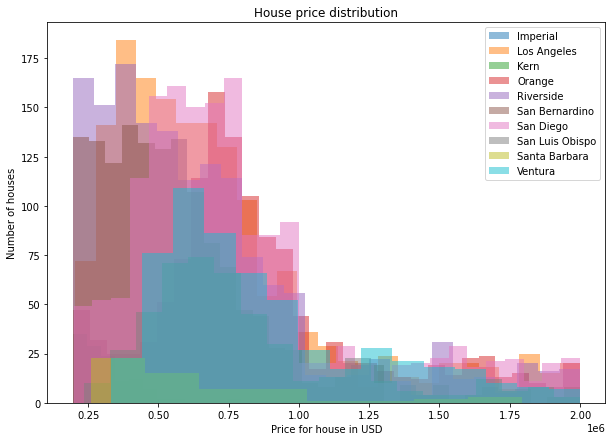

In [84]:
group = [imperial_houses, los_angeles_houses, kern_houses, orange_houses, riverside_houses, san_bernandino_houses, san_diego_houses, san_luis_obispo_houses, santa_barbara_houses, ventura_houses]
group_name = ['Imperial', 'Los Angeles', 'Kern', 'Orange', 'Riverside', 'San Bernardino', 'San Diego', 'San Luis Obispo', 'Santa Barbara', 'Ventura']

histogram_creator(group, group_name)

### It would be interesting to see is a scatterplot of the prices and the square meters of the houses.

In [85]:
def scatterplot(dataframe):
    '''
    Creates scatterplot between the price and the square meters of the house
    '''
    
    plt.figure(figsize = (10,7))
    
    plt.scatter(dataframe['price'], dataframe['sq_m'], s = 3)

    plt.title('Square meters/price map')
    plt.xlabel('Price of the house in US Dollars')
    plt.ylabel('Square meters')

    plt.show()

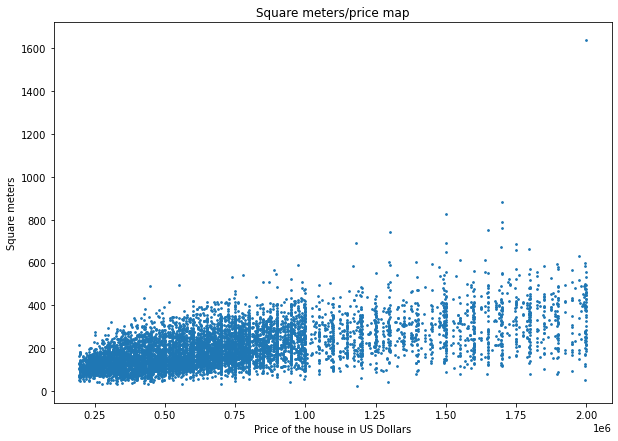

In [86]:
scatterplot(houses_df_for_choropleth)

### We can see that there is one house, which costs around 2 million dollars, which has 1600 square meters under the roof and it might be outlier, but it might be something normal if for example that house is old or remote.
### There are other houses that stand up from the crowd, but is it possible, because we are looking at houses in California. The majority of the prices are below 1 million dollars.

In [87]:
houses_df_for_choropleth[(houses_df_for_choropleth['sq_m'] > 1500)]

image_id                street      city       state        country  \
4648      8292  8531 Glendale Avenue  Hesperia  California  United States   

                                           full_address  n_city  n_bed  \
4648  8531, Glendale Avenue, Hesperia, San Bernardin...     143      9   

      n_bath  sq_m   sq_f    price   latitude   longitude            name  
4648       8  1641  17667  1999888  34.406746 -117.241907  San Bernardino

In [88]:
choropleth_layer_icons_folium_map_generator(houses_df_for_choropleth[(houses_df_for_choropleth['sq_m'] > 1500)], './california_json.txt')

### We can see if there is a correlation between the columns in the DataFrame as well.

In [89]:
houses_df_for_choropleth.corr()

image_id    n_city     n_bed    n_bath      sq_m      sq_f  \
image_id   1.000000  0.082566  0.093188  0.060927  0.118579  0.118620   
n_city     0.082566  1.000000 -0.000527  0.003344  0.012746  0.012733   
n_bed      0.093188 -0.000527  1.000000  0.613082  0.663867  0.663811   
n_bath     0.060927  0.003344  0.613082  1.000000  0.721692  0.721693   
sq_m       0.118579  0.012746  0.663867  0.721692  1.000000  0.999995   
sq_f       0.118620  0.012733  0.663811  0.721693  0.999995  1.000000   
price      0.052471  0.049916  0.354227  0.456965  0.589993  0.590011   
latitude  -0.101307 -0.044034 -0.039733 -0.007422 -0.036154 -0.036145   
longitude -0.144422 -0.015192  0.073306  0.100707  0.143766  0.143735   

              price  latitude  longitude  
image_id   0.052471 -0.101307  -0.144422  
n_city     0.049916 -0.044034  -0.015192  
n_bed      0.354227 -0.039733   0.073306  
n_bath     0.456965 -0.007422   0.100707  
sq_m       0.589993 -0.036154   0.143766  
sq_f       0.590011 -0.036145   0.143735  
price      1.000000 -0.129917  -0.078780  
latitude  -0.129917  1.000000  -0.715235  
longitude -0.078780 -0.715235   1.000000

### We can see the obvious that the number of different types of rooms are correlated to the area of the property and that the square meters column is the same as square feet one, but we created it that way.

# 
### 
### We can use the JSON data and read it from link and we can represent it as Layer. 
### Please note that we have extra features here - in the upper right corner we can change the general map layer.
### We can add more features to the map if we want. Note that we can turn on and off the heatmap and the Counties layer as well.

In [90]:
def county_layer_heatmap_folium_map_generator(dataframe, layer_url):
    '''
    Creates heatmap from the 'latitude' and 'longitude' columns of a dataframe
    '''
    
    url = (layer_url)
    california_geojson = f"{url}/california-counties.geojson"
    
    
    folium_map = folium.Map(width = WIDTH, height = HEIGHT, zoom_start = ZOOM_START, location = mean_coordinates)
    
   
    # add tile layers to the map
    tiles = ['openstreetmap', 'cartodbpositron', 'stamenterrain', 'stamentoner', 'stamenwatercolor', 'cartodbdark_matter']
    for tile in tiles:
        folium.TileLayer(tile).add_to(folium_map)
        
    
    heat_data = [[row['latitude'],row['longitude']] for index, row in dataframe.iterrows()]
    HeatMap(heat_data).add_to(folium_map)
    
    #adding the layer to the map
    folium.GeoJson(california_geojson, name="geojson").add_to(folium_map)
    folium.LayerControl().add_to(folium_map)
    
    # places the map in borders
    fig = Figure(width = WIDTH, height = HEIGHT)
    fig.add_child(folium_map)
    
    return fig

In [91]:
county_layer_heatmap_folium_map_generator(houses_df_for_choropleth, "https://raw.githubusercontent.com/codeforamerica/click_that_hood/master/public/data")

### 

### Now we saw that the code works, we can filter all the houses that are located in 'Los Angeles' using the functions from above but this time we won't slice the dataframe

In [92]:
los_angeles_house_indices = county_filter(21, houses_df_for_choropleth) 

### We can see that Los Angeles is represented by 1618 houses.

In [93]:
len(los_angeles_house_indices)

1618

### We can plot all the houses and see if they are really in Los Angeles County. First we need to instantiate new dataframe - 'los_angeles_county_houses_df', which has only those rows.

In [94]:
los_angeles_county_houses_df = houses_df_for_choropleth.iloc[los_angeles_house_indices]
los_angeles_county_houses_df.reset_index(drop = True, inplace=True)
los_angeles_county_houses_df.head()

image_id                  street         city       state        country  \
0        10  38833 Gorman Post Road       Gorman  California  United States   
1       246  49820 Gorman Post Road       Gorman  California  United States   
2       326         4332 BEN Avenue  Studio City  California  United States   
3       328       1345 Selvas Place     Glendale  California  United States   
4       329           4911 N Algoma   Eagle Rock  California  United States   

                                        full_address  n_city  n_bed  n_bath  \
0  38833, Gorman Post Road, Gorman, California, 9...     129      3       2   
1  49820, Gorman Post Road, Gorman, California, 9...     129      3       3   
2  4332, Ben Avenue, Studio City, Los Angeles, Ca...     360      3       2   
3  1345, Selvas Place, Glendale, California, 9120...     126      3       2   
4  4911, Algoma Avenue, Eagle Rock, Los Angeles, ...     106      3       3   

   sq_m  sq_f    price   latitude   longitude         name  
0   376  4044  1350000  34.783047 -118.809138  Los Angeles  
1   233  2503   449000  34.796671 -118.855765  Los Angeles  
2   203  2185  1095000  34.149152 -118.394167  Los Angeles  
3   152  1635  1075000  34.182255 -118.238712  Los Angeles  
4   184  1980  1449700  34.133911 -118.205311  Los Angeles

### The result can be found in the cell below.

In [95]:
county_layer_heatmap_folium_map_generator(los_angeles_county_houses_df, "https://raw.githubusercontent.com/codeforamerica/click_that_hood/master/public/data")

### In order to make color coding and represent the expensive and cheap properties we need to get the lowest price and the highest price of the Los Angeles County houses DataFrame.

In [96]:
los_angeles_county_houses_df['price'].min(), los_angeles_county_houses_df['price'].max()

(204900, 1999999)

In [97]:
def colormap_folium_map_generator(dataframe, layer_url):
    '''
    Creates a colormap of the houses - shows the house location and the depth of the color depicts the price
    '''
    
    
    url = (layer_url)
    california_geojson = f"{url}/california-counties.geojson"
    
    
    min_price = dataframe['price'].min()
    max_price = dataframe['price'].max()

    #colormap - options
    colormap = cm.LinearColormap(colors = ['lightgreen','green'],
                                 index = [min_price, max_price],
                                 vmin = min_price, vmax = max_price,
                                 caption = 'Price distribution')
    

    #map instantiating
    folium_map = folium.Map(width = WIDTH, height = HEIGHT, zoom_start = 8.3, location = [dataframe['latitude'].mean(), dataframe['longitude'].mean()])

    # add tile layers to the map
    tiles = ['openstreetmap', 'cartodbpositron', 'stamenterrain', 'stamentoner', 'stamenwatercolor', 'cartodbdark_matter']
    for tile in tiles:
        folium.TileLayer(tile).add_to(folium_map) 

    #
    for loc, price in zip(zip(list(dataframe['latitude']), list(dataframe['longitude'])), list(dataframe['price'])):
        folium.Circle(
            location = loc,
            radius = 10,
            fill = True,
            color = colormap(price),
            fill_opacity=0.7
            ).add_to(folium_map)

    folium_map.add_child(colormap)

    folium.GeoJson(california_geojson, name="geojson").add_to(folium_map)
    folium.LayerControl().add_to(folium_map)
 
    
    # places the map in borders
    fig = Figure(width = WIDTH, height = HEIGHT)
    fig.add_child(folium_map)
    
    #display(folium_map)
    return fig 

In [98]:
colormap_folium_map_generator(los_angeles_county_houses_df, "https://raw.githubusercontent.com/codeforamerica/click_that_hood/master/public/data")

In [99]:
def colormap_with_price_tags_folium_map_generator(dataframe, layer_url):
    '''
    Creates a colormap of the houses - shows the house location and the depth of the color depicts the price.
    We can see the price of some of the properties.
    '''
    
    url = (layer_url)
    california_geojson = f"{url}/california-counties.geojson"
    
    
    min_price = dataframe['price'].min()
    max_price = dataframe['price'].max()

    #colormap - options
    colormap = cm.LinearColormap(colors = ['lightgreen','green'],
                                 index = [min_price, max_price],
                                 vmin = min_price, vmax = max_price,
                                 caption = 'Price distribution')
    

    #map instantiating
    folium_map = folium.Map(width = WIDTH, height = HEIGHT, zoom_start = 8.3, location = [dataframe['latitude'].mean(), dataframe['longitude'].mean()])

    # add tile layers to the map
    tiles = ['openstreetmap', 'cartodbpositron', 'stamenterrain', 'stamentoner', 'stamenwatercolor', 'cartodbdark_matter']
    for tile in tiles:
        folium.TileLayer(tile).add_to(folium_map) 

    #
    for loc, price in zip(zip(list(dataframe['latitude']), list(dataframe['longitude'])), list(dataframe['price'])):
        folium.Circle(
            location = loc,
            radius = 10,
            fill = True,
            color = colormap(price),
            fill_opacity=0.7
            ).add_to(folium_map)

    folium_map.add_child(colormap)
    
    
    #for showing the price of the house - using shorter dataframe for clarity
    for i in range(len(dataframe[0:100])):
        folium.Marker(dataframe[['latitude','longitude']].iloc[i].tolist(), popup = dataframe['price'].iloc[i], tooltip = "Click me!", icon = None).add_to(folium_map)           

    

    folium.GeoJson(california_geojson, name="geojson").add_to(folium_map)
    folium.LayerControl().add_to(folium_map)


    # places the map in borders
    fig = Figure(width = WIDTH, height = HEIGHT)
    fig.add_child(folium_map)
    
    #display(folium_map)
    return fig 

In [100]:
colormap_with_price_tags_folium_map_generator(los_angeles_county_houses_df, "https://raw.githubusercontent.com/codeforamerica/click_that_hood/master/public/data")

### 
### We can do something similar to the above plot using Contour Lines Map. We can turn off the JSON County layer, change the map layer or a combination of the two in order to see the price contour lines better.

In [109]:
def price_contour_lines_folium_map_generator(dataframe, layer_url):
    '''
    Creates a contour colormap of the houses where the color depicts the price.
    '''
    
    url = (layer_url)
    california_geojson = f"{url}/california-counties.geojson"
    
    
    min_price = dataframe['price'].min()
    max_price = dataframe['price'].max()

    
    # Colormap - options 
    colors = ['ivory', 'yellow', 'orange', 'red', 'darkred']
    levels = len(colors)
    colormap     = cm.LinearColormap(colors, vmin = min_price, vmax = max_price).to_step(levels)
    

    # Convertion from dataframe to array
    x = np.asarray(dataframe['longitude'].tolist())
    y = np.asarray(dataframe['latitude'].tolist())
    z = np.asarray(dataframe['price'].tolist()) 
    
    
    # Make a grid
    x_arr = np.linspace(np.min(x), np.max(x), 600)
    y_arr = np.linspace(np.min(y), np.max(y), 600)
    x_mesh, y_mesh = np.meshgrid(x_arr, y_arr)


    # Grid the 'elevation' - in our case the third dimension is the price of the property
    z_mesh = griddata((x, y), z, (x_mesh, y_mesh), method='linear')

    
    # Use Gaussian filter to smoothen the contour
    sigma = [5, 5]
    z_mesh = sp.ndimage.filters.gaussian_filter(z_mesh, sigma, mode='constant')

    # Create the contour
    contourf = plt.contourf(x_mesh, y_mesh, z_mesh, levels, alpha = 0.7,
                            colors = colors, linestyles = 'None', vmin = min_price, vmax = max_price)


    # Convert matplotlib contourf to geojson
    geojson = geojsoncontour.contourf_to_geojson(
        contourf = contourf,
        min_angle_deg = 3.0,
        ndigits = 5,
        stroke_width = 1,
        fill_opacity = 0.9)

    
    # map instantiating
    folium_map = folium.Map(width = WIDTH, height = HEIGHT, zoom_start = 8.3, location = [dataframe['latitude'].mean(), dataframe['longitude'].mean()])

    # add tile layers to the map
    tiles = ['openstreetmap', 'cartodbpositron', 'stamenterrain', 'stamentoner', 'stamenwatercolor', 'cartodbdark_matter']
    for tile in tiles:
        folium.TileLayer(tile).add_to(folium_map) 

    
    # Plot the contour on Folium map
    folium.GeoJson(
        geojson,
        style_function=lambda x: {
            'color':     x['properties']['stroke'],
            'weight':    x['properties']['stroke-width'],
            'fillColor': x['properties']['fill'],
            'opacity':   1
        }).add_to(folium_map)
    
    

    folium.GeoJson(california_geojson, name="geojson").add_to(folium_map)
    folium.LayerControl().add_to(folium_map)


    # Add the colormap to the folium map for legend
    colormap.caption = 'Property prices'
    folium_map.add_child(colormap)

    
    # places the map in borders
    fig = Figure(width = WIDTH, height = HEIGHT)
    fig.add_child(folium_map)
    
    #display(folium_map)
    return fig 

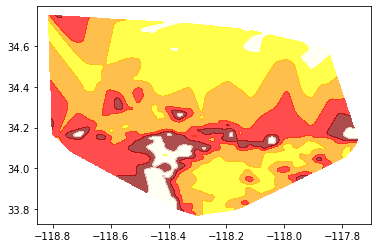

In [110]:
price_contour_lines_folium_map_generator(los_angeles_county_houses_df, 'https://raw.githubusercontent.com/codeforamerica/click_that_hood/master/public/data')

### 

### 

### 

### The problem with the above map is that is shows all the houses, but the price depends on the number of rooms, bathrooms, how big the house is and the location, because of that we can make filter so when we are looking for the price of a house we can select what we are after.
### In the cell below I'll represent the average price of the house we are after using functions, in a cell after it I'll do it with Class.
### I'll keep the solutions in one cell so it would be more understandable.

In [111]:
# functions solution

def los_angeles_county_address_converter(county_address):
    '''
    This function asks for Los Angeles address and it converts the address into longitude/latitude coordinates
    '''
    
    los_angeles_address = county_address
    los_angeles_latlong_list = []

    location = Nominatim(user_agent='myGeocoder').geocode(los_angeles_address, timeout=None)
    
    try:
        los_angeles_latlong_list.append([location.latitude, location.longitude])
    except:
        return "We couldn't find that address, please try again."
    
    return los_angeles_latlong_list[0]
    

def los_angeles_county_address_longitude_latitude_filter(latitude_longitude_coordinates, county_dataframe):
    '''
    We create a radius around which we will filter houses for more precision and more accurate prices
    For Your Information: At the equator for longitude and for latitude anywhere, the following approximations are valid:
    1° = 111 km (or 60 nautical miles) -  0.1° = 11.1 km  -  0.01° = 1.11 km.
    '''
    
    # here we restrict the distance 
    # 0.02 represents 2km distance
    min_latitude = latitude_longitude_coordinates[0] - 0.02
    max_latitude = latitude_longitude_coordinates[0] + 0.02
    
    min_longitude = latitude_longitude_coordinates[1] - 0.02
    max_longitude = latitude_longitude_coordinates[1] + 0.02
    
    
    # here we put filter on the houses from the dataframe
    selection_criteria = (county_dataframe['longitude'] > min_longitude) & (county_dataframe['longitude'] < max_longitude) & (county_dataframe['latitude'] > min_latitude) & (county_dataframe['latitude'] < max_latitude)
    
    # county_dataframe[selection_criteria]
    return county_dataframe[selection_criteria]




#-----------------


lat_long_la_coords = los_angeles_county_address_converter('Bennett Drive, Hollywood Hills, Los Angeles, California')

# dataframe of the surrounding houses to the given address
neighborhood_houses_df = los_angeles_county_address_longitude_latitude_filter(lat_long_la_coords, los_angeles_county_houses_df)
neighborhood_houses_df


# the last step is to filter the remaining houses and to calculate the average price - it is the price we are after
# the conditions can vary depending on the needs of the customer - they can have 1 condition, 2 conditions or more
conditions = (neighborhood_houses_df['n_bath'] > 1) & (neighborhood_houses_df['sq_m'] < 200)

#we can see the remaining houses that match the customer's requirements
neighborhood_houses_df[conditions]

#and finally we can tell approximate price for the house he is after
average_house_price = neighborhood_houses_df[conditions]['price'].sum() // neighborhood_houses_df[conditions].shape[0]
average_house_price

1312800

In [112]:
# Class solution


class Filters(object):
    
    def __init__(self):
        pass
    
    
    def los_angeles_county_address_converter(self, county_address):
        '''
        This function asks for Los Angeles address and it converts the address into longitude/latitude coordinates
        '''

        los_angeles_address = county_address
        los_angeles_latlong_list = []

        location = Nominatim(user_agent='myGeocoder').geocode(los_angeles_address, timeout=None)

        try:
            los_angeles_latlong_list.append([location.latitude, location.longitude])
        except:
            return "We couldn't find that address, please try again."
        
        coord_list = los_angeles_latlong_list[0]

        def los_angeles_county_address_longitude_latitude_filter(county_dataframe):
            '''
            We create a radius around which we will filter houses for more precision and more accurate prices
            At the equator for longitude and for latitude anywhere, the following approximations are valid:
            1° = 111 km (or 60 nautical miles) -  0.1° = 11.1 km  -  0.01° = 1.11 km.
            '''

            # here we restrict the distance 
            # 0.02 represents 2km distance
            min_latitude = coord_list[0] - 0.02
            max_latitude = coord_list[0] + 0.02

            min_longitude = coord_list[1] - 0.02
            max_longitude = coord_list[1] + 0.02


            # here we put filter on the houses from the dataframe
            selection_criteria = (county_dataframe['longitude'] > min_longitude) & (county_dataframe['longitude'] < max_longitude) & (county_dataframe['latitude'] > min_latitude) & (county_dataframe['latitude'] < max_latitude)
           
            # county_dataframe[selection_criteria]
            return county_dataframe[selection_criteria]
    
        return los_angeles_county_address_longitude_latitude_filter
    


# we can instantiate 'Filters' class object - 'neighborhood_houses_df', which passes as agruments the address, 
# where we want to search and the dataframe
neighborhood_houses_df = Filters().los_angeles_county_address_converter('Bennett Drive, Hollywood Hills, Los Angeles, California')(los_angeles_county_houses_df)
neighborhood_houses_df


# the last step is to filter the remaining houses and to calculate the average price - it is the price we are after
# the conditions can vary depending on the needs of the customer - they can have 1 condition, 2 conditions or more
conditions = (neighborhood_houses_df['n_bath'] > 1) & (neighborhood_houses_df['sq_m'] < 200)

# we can see the remaining houses that match the customer's requirements
neighborhood_houses_df[conditions]

# and finally we can tell approximate price for the house he is after
average_house_price = neighborhood_houses_df[conditions]['price'].sum() // neighborhood_houses_df[conditions].shape[0]
average_house_price

1312800

### We can show the houses after the filter. It is similar to 'colormap_with_price_tags_folium_map_generator' function we defined earlier but this time we added circle marker with the given address, the radius of the circle is 2km. We will use the same address as in the given examples above - 'Bennett Drive, Hollywood Hills, Los Angeles, California'.

In [113]:
def colormap_with_price_tags_with_cirle_folium_map_generator(dataframe, layer_url, address):
    '''
    Creates a colormap of the houses - shows the house location and the depth of the color depicts the price.
    We can see the price of some of the properties.
    '''
    
    url = (layer_url)
    california_geojson = f"{url}/california-counties.geojson"
    
    
    min_price = dataframe['price'].min()
    max_price = dataframe['price'].max()

    # colormap - options
    colormap = cm.LinearColormap(colors = ['lightgreen','green'],
                                 index = [min_price, max_price],
                                 vmin = min_price, vmax = max_price,
                                 caption = 'Price distribution')
    

    # map instantiating
    folium_map = folium.Map(width = WIDTH, height = HEIGHT, zoom_start = 8.3, control_scale = True,
                            location = [dataframe['latitude'].mean(), dataframe['longitude'].mean()])

    # add tile layers to the map
    tiles = ['openstreetmap', 'cartodbpositron', 'stamenterrain', 'stamentoner', 'stamenwatercolor', 'cartodbdark_matter']
    for tile in tiles:
        folium.TileLayer(tile).add_to(folium_map) 

    #
    for loc, price in zip(zip(list(dataframe['latitude']), list(dataframe['longitude'])), list(dataframe['price'])):
        folium.Circle(
            location = loc,
            radius = 10,
            fill = True,
            color = colormap(price),
            fill_opacity=0.7
            ).add_to(folium_map)

    folium_map.add_child(colormap)
    
    
    # for showing the price of the house - using shorter dataframe for clarity
    for i in range(len(dataframe[0:100])):
        folium.Marker(dataframe[['latitude','longitude']].iloc[i].tolist(), 
                      popup = f"House price - {dataframe['price'].iloc[i]}$ , House street - {dataframe['street'].iloc[i]}", 
                      tooltip = "Click me!", icon = None).add_to(folium_map)           

    
    # circle instantiating
    folium.Circle(location = (los_angeles_county_address_converter(address)), 
                  radius = 1000, color = 'green', 
                  fill_color = 'yellow').add_to(folium_map)
    
    

    folium.GeoJson(california_geojson, name="geojson").add_to(folium_map)
    folium.LayerControl().add_to(folium_map)


    # places the map in borders
    fig = Figure(width = WIDTH, height = HEIGHT)
    fig.add_child(folium_map)
    
    #display(folium_map)
    return fig 

### You can see by clicking on the blue marker that the price and house street is writen in.
### We can see that some of the houses are outside of the cirle, that is because we have created the location filter as rectange.

In [114]:
colormap_with_price_tags_with_cirle_folium_map_generator(neighborhood_houses_df[conditions], 'https://raw.githubusercontent.com/codeforamerica/click_that_hood/master/public/data', 'Bennett Drive, Hollywood Hills, Los Angeles, California')

### We can create word cloud as a side mini project.
### Please note: depending on the column, we can split the text or keep it as one piece. If  'column_name' is 'full_address' or 'street' we would like to split the text into words and to se the most common ones. If 'column_name' is 'name' (County names) we would like to keep it as one word - for example 'Los Angeles' instead of 'Los' and 'Angeles'.

In [115]:
def word_cloud_image(dataframe, column_name):
    '''
    Creates word cloud imade from Dataframe and a column from it
    '''
    
    # we need to know if the words in the column that we have need to stay together
    # or they can be separated into individual words
    
    columns = ['full_address', 'street']
    
    if column_name in columns:
        # we gather all the rows from the column into a list
        all_row_titles = " ".join(dataframe[column_name].tolist())

        # splitting into words and removing everything that is number or letter
        all_words = re.split('\W+', all_row_titles)

        # removes empty strings
        all_words = [word for word in all_words if word != '']

        # creates dictionary
        all_words_in_titles_counter = Counter(all_words)

        # we can see the most common 20 words, if we return it
        all_words_in_titles_counter.most_common(20)

        # cleaning the words we have with English stop words
        cleaned_words = [word for word in all_words if word not in set(stopwords.words('english'))]


        cleaned_words_counter = Counter(cleaned_words)

        cloud = wordcloud.WordCloud(width = 400, height = 400)
        cloud.generate_from_frequencies(dict(cleaned_words_counter.most_common(20)))
        return cloud.to_image()
    
    if column_name not in columns:
        counter_dictionary = Counter(dataframe[column_name])
        cloud = wordcloud.WordCloud(width = 400, height = 400)
        cloud.generate_from_frequencies(dict(counter_dictionary.most_common(20)))
        return cloud.to_image()

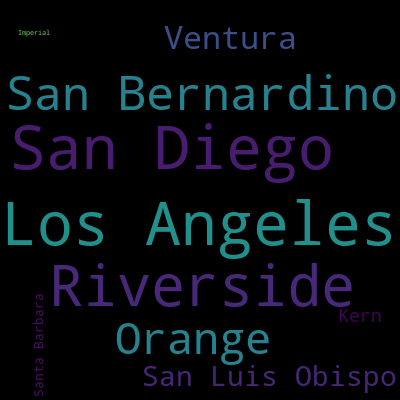

In [116]:
word_cloud_image(houses_df_for_choropleth, 'name')

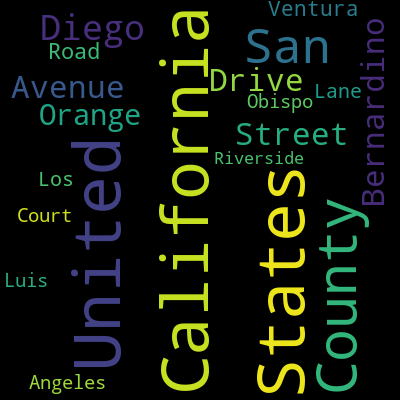

In [117]:
word_cloud_image(houses_df_for_choropleth, 'full_address')

## 
## 
## 
### We can do a second and last for this Notebook side project. Predicting the County name of a house. We will use Supervised Learning Classification algorithm 'Linear Discriminant Analysis' for this.
### First let's load the DataFrame.

In [118]:
houses_dataframe = pd.read_csv('./houses_df_for_choropleth.csv', index_col = 'Unnamed: 0')

In [119]:
houses_dataframe

image_id                   street           city       state  \
0            2          2304 Clark Road       Imperial  California   
1            4    2207 R Carrillo Court       Calexico  California   
2            6      1100 CAMILIA Street       Calexico  California   
3            7      803 Chaparral Court        Brawley  California   
4           10   38833 Gorman Post Road         Gorman  California   
...        ...                      ...            ...         ...   
8694     15467  2032 Keltic Lodge Drive         Oxnard  California   
8695     15469  4156 Sterlingview Drive       Moorpark  California   
8696     15470       4355 Avenida Prado  Thousand Oaks  California   
8697     15472         36 Kunkle Street       Oak View  California   
8698     15473      4562 Eastbourne Bay         Oxnard  California   

            country                                       full_address  \
0     United States  2304, Clark Road, Imperial, California, 92243,...   
1     United States  2207, R Carrillo Court, Calexico, California, ...   
2     United States  1100, Camilia Street, Calexico, California, 92...   
3     United States  803, Chaparral Court, Brawley, California, 922...   
4     United States  38833, Gorman Post Road, Gorman, California, 9...   
...             ...                                                ...   
8694  United States  2032, Keltic Lodge Drive, Oxnard, Ventura Coun...   
8695  United States  4156, Sterlingview Drive, Moorpark, Ventura Co...   
8696  United States  4355, Avenida Prado, Thousand Oaks, Ventura Co...   
8697  United States  36, Kunkle Street, Oak View, Ventura County, C...   
8698  United States  4562, Eastbourne Bay, Oxnard, Ventura County, ...   

      n_city  n_bed  n_bath  sq_m  sq_f    price   latitude   longitude  \
0        152      3       1    74   800   273950  32.819845 -115.561435   
1         55      4       3   237  2547   385100  32.692297 -115.480164   
2         55      4       3   257  2769   415000  32.681839 -115.482385   
3         48      5       2   242  2600   545000  32.964799 -115.554026   
4        129      3       2   376  4044  1350000  34.783047 -118.809138   
...      ...    ...     ...   ...   ...      ...        ...         ...   
8694     261      5       3   414  4457   975000  34.222191 -119.211936   
8695     227      5       4   380  4092   949000  34.265780 -118.908296   
8696     372      5       3   258  2773   949900  34.239351 -118.855522   
8697     253      4       2   194  2086   997000  34.394428 -119.301762   
8698     261      2       2   113  1216   975000  34.183864 -119.232682   

             name  
0        Imperial  
1        Imperial  
2        Imperial  
3        Imperial  
4     Los Angeles  
...           ...  
8694      Ventura  
8695      Ventura  
8696      Ventura  
8697      Ventura  
8698      Ventura  

[8699 rows x 15 columns]

### We can take a look at the County names

In [120]:
houses_dataframe['name'].unique()

array(['Imperial', 'Los Angeles', 'Kern', 'Orange', 'Riverside',
       'San Bernardino', 'San Diego', 'San Luis Obispo', 'Santa Barbara',
       'Ventura'], dtype=object)

### We will create a copy of 'houses_dataframe', because we will have to transform it. The new Dataframe will be called with the original name 'houses_dataframe_new'. 
### The Machine Learning algorithm only takes columns with numbers, so the columns with text ('str') have to be deleted. 

In [121]:
# mixing the data
houses_dataframe_new = houses_dataframe.sample( len(houses_dataframe) )

# deleting the columns with text
houses_dataframe_new.drop(['image_id', 'street', 'city', 'state', 'country', 'full_address'], axis = 1, inplace = True)

### Next the column that we need to predict (called 'target') needs to be with numbers as well. In this case the column called 'name' from before. We can change the County names with numbers and later on we can come here again and see which number corresponds to which County name.

In [122]:
houses_dataframe_new.replace({'name': 'Imperial'}, '0', inplace = True)
houses_dataframe_new.replace({'name': 'Los Angeles'}, '1', inplace = True)
houses_dataframe_new.replace({'name': 'Kern'}, '2', inplace = True)
houses_dataframe_new.replace({'name': 'Orange'}, '3', inplace = True)
houses_dataframe_new.replace({'name': 'Riverside'}, '4', inplace = True)
houses_dataframe_new.replace({'name': 'San Bernardino'}, '5', inplace = True)
houses_dataframe_new.replace({'name': 'San Diego'}, '6', inplace = True)
houses_dataframe_new.replace({'name': 'San Luis Obispo'}, '7', inplace = True)
houses_dataframe_new.replace({'name': 'Santa Barbara'}, '8', inplace = True)
houses_dataframe_new.replace({'name': 'Ventura'}, '9', inplace = True)

houses_dataframe_new['name'] = houses_dataframe_new['name'].astype(np.float64)

### We can see that we have only columns with numbers.

In [123]:
houses_dataframe_new.dtypes

n_city         int64
n_bed          int64
n_bath         int64
sq_m           int64
sq_f           int64
price          int64
latitude     float64
longitude    float64
name         float64
dtype: object

### First I will go slowly and introduce the concept, later on I will use functions.
### The column we want to predict is called 'target'. It should be the column 'name'. The other columns of the DataFrame will be used as 'data'.

In [124]:
houses_target = houses_dataframe_new['name']
houses_data = houses_dataframe_new.drop(['name'], axis = 1)

In [125]:
houses_dataframe_scaled = MinMaxScaler().fit_transform(houses_dataframe_new)

### We instantiate object 'linda' of class 'LinearDiscriminantAnalysis'

In [126]:
linda = LinearDiscriminantAnalysis()

### We fit the model or train it with the 'data' and 'target' columns.

In [127]:
linda.fit(houses_data, houses_target)

LinearDiscriminantAnalysis()

### Results from the Linear Discriminant Analysis

In [128]:
linda.transform(houses_data)

array([[-4.19725107,  2.80326427,  0.75420923, ..., -0.37534224,
         1.2155559 , -0.06873422],
       [12.68650599,  0.84585339,  0.34598464, ..., -1.04132407,
         1.56634963,  0.01921855],
       [-0.03419797,  0.52669881, -0.79673056, ...,  1.02263386,
        -1.08735343,  0.2019242 ],
       ...,
       [ 0.33501415,  0.71216128,  0.02170178, ..., -0.36011459,
         1.33900896, -0.84661511],
       [-0.04248282, -1.22843605, -0.99435795, ...,  0.32599904,
        -1.17021598, -1.26367567],
       [-4.75434472, -3.26889581, -2.54450655, ...,  0.60207959,
        -0.4881158 ,  1.41741155]])

### We can see the predicted values and the actual values, remember the values mean County name

In [129]:
list(zip(linda.transform(houses_data).flatten(), houses_target))[:5]

[(-4.197251070167331, 4.0),
 (2.803264273378257, 7.0),
 (0.7542092305990031, 5.0),
 (-1.428194681358615, 6.0),
 (-0.22101883433138658, 4.0)]

### We can see only the first pair.

In [130]:
list(zip(linda.transform(houses_data).flatten(), houses_target))[0]

(-4.197251070167331, 4.0)

In [131]:
len(list(zip(linda.transform(houses_data).flatten(), houses_target)))

8699

### We can obtain the only the values of linda with the for loop below.

In [132]:
linda_values = []
for i in range(len(houses_data)):
    linda_values.append(list(zip(linda.transform(houses_data).flatten(), houses_target))[i][0])

len(linda_values)

8699

### We will use those values in ploting a scatterplot. As you can see each number is represented as different color. On the other hand it is not very visible. It looks like a mixture random points.

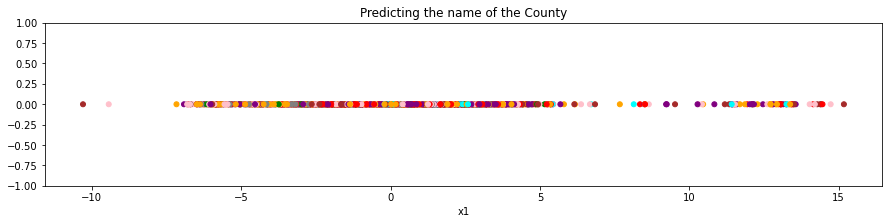

In [133]:
x = linda_values
y = [0] * len(houses_data)

plt.figure(figsize = (15,3))
plt.scatter(x, y, s = 25,
            c = houses_target.map({0 : 'blue',
                                   1 : 'orange',
                                   2 : 'green',
                                   3 : 'red',
                                   4 : 'purple',
                                   5 : 'brown',
                                   6 : 'pink',
                                   7 : 'gray',
                                   8 : 'olive',
                                   9 : 'cyan'}))

plt.title('Predicting the name of the County')
plt.ylim(-1,1)
plt.xlabel('x1')
plt.show()

### Let's see the accuracy. Just a little over 90%.

In [134]:
linda.score(houses_data, houses_target)

0.9098746982411772

## 

### We can take a closer look and instead of taking all the county names and numbers. We can only focus ourselves on only two of them. 'Los Angeles' with number 1 and 'San Bernardino' with number 5.
### We instantiate new DataFrame 'short_houses_dataframe' to contain only the houses, located in 'Los Angeles' and 'San Bernandino'.

In [135]:
short_houses_dataframe = pd.concat([houses_dataframe_new[houses_dataframe_new['name'] == 1.0], houses_dataframe_new[houses_dataframe_new['name'] == 5.0]], axis = 0 )

In [136]:
short_houses_dataframe.head(3)

n_city  n_bed  n_bath  sq_m  sq_f   price   latitude   longitude  name
668      267      5       3   277  2987  369000  34.577410 -118.014604   1.0
890       69      2       1    94  1008  479900  33.836223 -118.282147   1.0
1717     323      3       1   183  1968  949500  34.110890 -118.116201   1.0

In [137]:
short_houses_dataframe.shape

(3079, 9)

### We can see the unique values of the County names to verify.

In [138]:
short_houses_dataframe['name'].unique()

array([1., 5.])

### We set the 'target' and 'data'.

In [139]:
short_houses_target = short_houses_dataframe['name']
short_houses_data = short_houses_dataframe.drop(['name'], axis = 1)

In [140]:
def linear_discriminant_analysis_function(dataframe, dataframe_data, dataframe_target):
    '''
    Function to calculate the linear discriminant analysis values.
    '''
    
    dataframe_scaled = MinMaxScaler().fit_transform(dataframe)
    
    linda = LinearDiscriminantAnalysis()
    
    linda.fit(dataframe_data, dataframe_target)


    #results from the Linear Discriminant Analysis
    linda.transform(dataframe_data)
    
    linda_values = []
    for i in range(len(dataframe_data)):
        linda_values.append(list(zip(linda.transform(dataframe_data).flatten(), dataframe_target))[i][0])
    
    return linda_values

In [141]:
short_linda_values = linear_discriminant_analysis_function(short_houses_dataframe, short_houses_data, short_houses_target)

### We can create scatterplot as before to see the result.

In [142]:
def scatterplot_linear_discriminant_analysis(linda_list, dataframe_target):
    '''
    Creates scatterplot of linear discriminant analysis values.
    '''

    x = linda_list
    y = [0] * len(linda_list)

    plt.figure(figsize = (15,3))
    plt.scatter(x, y, s = 25,
                c = dataframe_target.map({0 : 'blue',
                                       1 : 'orange',
                                       2 : 'green',
                                       3 : 'red',
                                       4 : 'purple',
                                       5 : 'brown',
                                       6 : 'pink',
                                       7 : 'gray',
                                       8 : 'olive',
                                       9 : 'cyan'}))

    plt.title('Predicting the name of the County')
    plt.ylim(-1,1)
    plt.xlabel('x1')
    plt.show()

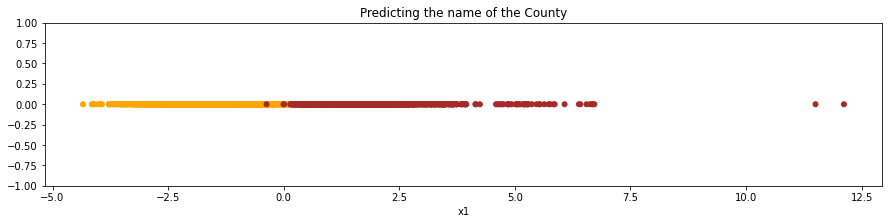

In [143]:
scatterplot_linear_discriminant_analysis(short_linda_values, short_houses_target)

### Now it seems more reasonable why we got agound 90% when we calculated linda values for all the Counties.
### Let's see the accuracy now.

In [144]:
linda.score(short_houses_data, short_houses_target)

0.8616433907112699

### 
### 
### We can try using train/test split model evaluation procedure. The purpose of train/test split is to split the data into two parts. We can train the model with 75% of the data and we can test it on the remaining 25%. The reason is that we know the right answer for the test part and we can see how accurate is the model.

In [145]:
short_houses_target = short_houses_dataframe['name']
short_houses_data = short_houses_dataframe.drop(['name'], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(short_houses_data, short_houses_target, random_state = 1)

### We can train the model with 'linear_discriminant_analysis_function' I created earlier.

In [146]:
short_linda_values_x_and_y_train = linear_discriminant_analysis_function(short_houses_dataframe, X_train, y_train)

### We can see the result with the scatterplot.

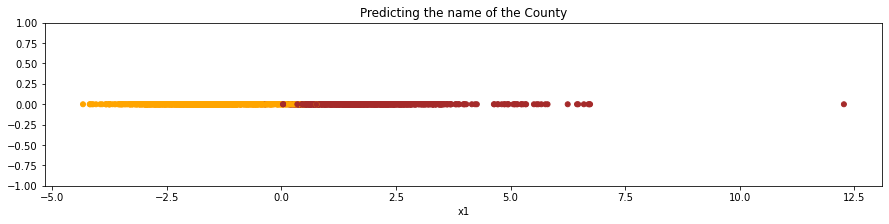

In [147]:
scatterplot_linear_discriminant_analysis(short_linda_values_x_and_y_train, y_train)

### Finally we can see the accuracy.

In [148]:
linda.score(X_train, y_train)

0.8609787786920745

### 
### We can see the first 5 couples of 'predicted/real numbers'

In [149]:
list((zip(linda.predict(X_test), y_test)))[:5]

[(3.0, 1.0), (1.0, 1.0), (1.0, 1.0), (4.0, 5.0), (5.0, 5.0)]

### We can calculate the accuracy on never seen rows of data. Please note that we are using the 'test' part of the DataFrame.

In [150]:
linda.score(X_test, y_test)

0.8636363636363636

### We can do that check manually if we wanted to. Comparing if the predicted values match with the actual values.

In [151]:
all_numbers = len(list((zip(linda.predict(X_test), y_test))))
number_correct = 0

for i in range( len(list((zip(linda.predict(X_test), y_test)))) ):
    if list((zip(linda.predict(X_test), y_test)))[i][0] == list((zip(linda.predict(X_test), y_test)))[i][1]:
        number_correct +=1

print(f'Count of correctly found numbers: {number_correct}')
print(f'Count of all numbers: {all_numbers}')
print(f'Percentage of correctly found numbers: {number_correct/all_numbers}')

Count of correctly found numbers: 665
Count of all numbers: 770
Percentage of correctly found numbers: 0.8636363636363636


### We can see that we got the same result as the 'linda.score' method.

### 
### 
### We can try another classifier such as K-nearest neighbors
### K stands for the number of observations in the training data that are 'nearest' to the measurements of the 'target'.
### We can again instantiate object of Class 'KNeighborsClassifier', fit or train the model and predict with the testing part of the dataset.

In [152]:
knn = KNeighborsClassifier(n_neighbors = 1)

In [153]:
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=1)

In [154]:
knn.predict(X_test)

array([1., 1., 1., 5., 5., 1., 5., 1., 1., 5., 5., 5., 5., 1., 5., 5., 1.,
       1., 1., 5., 5., 1., 1., 1., 5., 1., 1., 1., 5., 1., 1., 1., 5., 5.,
       1., 1., 1., 5., 5., 1., 5., 5., 5., 1., 5., 1., 5., 5., 1., 5., 5.,
       1., 1., 1., 5., 1., 1., 5., 1., 5., 1., 5., 1., 5., 1., 1., 5., 5.,
       1., 1., 5., 1., 1., 1., 1., 5., 1., 1., 5., 5., 5., 1., 1., 1., 1.,
       5., 5., 5., 5., 5., 5., 1., 5., 1., 5., 5., 5., 1., 1., 5., 1., 1.,
       1., 5., 5., 5., 1., 5., 5., 1., 5., 5., 1., 5., 5., 1., 5., 1., 5.,
       5., 1., 5., 5., 5., 1., 1., 5., 5., 1., 1., 5., 1., 5., 5., 1., 1.,
       1., 5., 5., 1., 1., 5., 5., 5., 1., 1., 1., 5., 1., 1., 1., 5., 5.,
       1., 5., 1., 1., 1., 1., 1., 5., 5., 1., 1., 1., 5., 5., 5., 1., 1.,
       1., 5., 5., 1., 1., 5., 1., 5., 5., 1., 1., 5., 5., 5., 1., 1., 1.,
       1., 5., 1., 5., 5., 1., 1., 1., 1., 1., 1., 5., 1., 5., 1., 1., 5.,
       5., 5., 5., 1., 1., 5., 1., 1., 5., 1., 1., 5., 1., 1., 1., 5., 5.,
       5., 5., 1., 1., 5.

In [155]:
knn.score(X_train, y_train)

1.0

In [156]:
knn.score(X_test, y_test)

0.7025974025974026

In [157]:
def k_nearest_neighbors_function(X_train, y_train, X_test, y_test, num_neighbors):
    '''
    K-nearest neighbors classificator.
    '''
    
    knn = KNeighborsClassifier(n_neighbors = num_neighbors)
    knn.fit(X_train, y_train)
    knn.predict(X_test)
    return knn.score(X_test, y_test)

In [158]:
numbers_list = [i for i in range(1,20)]
knn_accuracy_list = []
for i in range(1,20):
    knn_accuracy_list.append(k_nearest_neighbors_function(X_train, y_train, X_test, y_test, i))
    
knn_accuracy_list[:5]

[0.7025974025974026,
 0.6610389610389611,
 0.6935064935064935,
 0.6636363636363637,
 0.6584415584415585]

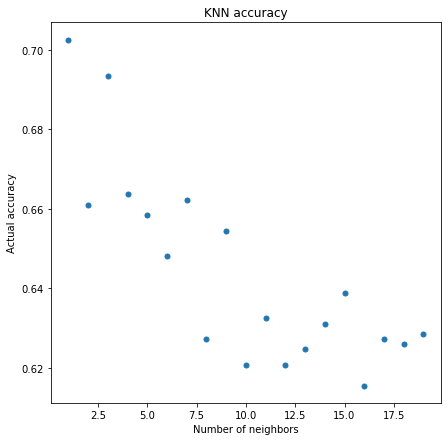

In [159]:
plt.figure(figsize = (7,7))
    
plt.scatter(numbers_list, knn_accuracy_list, s = 25)

plt.title('KNN accuracy')
plt.xlabel('Number of neighbors')
plt.ylabel('Actual accuracy')

plt.show()

### We can see that in this case with the increasement of the number of neighbors the accuracy is plummeting.

### 
### 
### 
### Thank you for your attention.
### 
### 

## 
## REFERENCES:
## 

### Dataset from Kaggle - House Prices and Images - SoCal
### By User - ted8080
### https://www.kaggle.com/ted8080/house-prices-and-images-socal

### 

### Geojson file with State California's counties 
### https://github.com/codeforamerica/click_that_hood/blob/master/public/data/california-counties.geojson
### Geojson Raw
### https://raw.githubusercontent.com/codeforamerica/click_that_hood/master/public/data/california-counties.geojson

### 

### How to install geopandas and create new environment
### https://medium.com/analytics-vidhya/fastest-way-to-install-geopandas-in-jupyter-notebook-on-windows-8f734e11fa2b

### 

### Checks if point is in polygon
### https://stackoverflow.com/questions/36399381/whats-the-fastest-way-of-checking-if-a-point-is-inside-a-polygon-in-python

### 

### Geocode
### https://towardsdatascience.com/geocode-with-python-161ec1e62b89

### 

### Folium
### https://www.youtube.com/watch?v=t9Ed5QyO7qY
### https://python-visualization.github.io/folium/quickstart.html
### http://python-visualization.github.io/folium/quickstart.html#Markers
### https://www.analyticsvidhya.com/blog/2020/06/guide-geospatial-analysis-folium-python/
### https://www.kaggle.com/daveianhickey/how-to-folium-for-maps-heatmaps-time-analysis
### https://towardsdatascience.com/choropleth-maps-with-folium-1a5b8bcdd392
### https://nbviewer.jupyter.org/github/python-visualization/folium/blob/v0.2.0/examples/Colormaps.ipynb
### https://stackoverflow.com/questions/56876620/unsure-how-to-use-colormap-with-folium-marker-plot
### https://www.kaggle.com/daveianhickey/how-to-folium-for-maps-heatmaps-time-analysis
### https://towardsdatascience.com/choropleth-maps-with-folium-1a5b8bcdd392
### https://blog.dominodatalab.com/creating-interactive-crime-maps-with-folium/

### 

### Creating Contour Lines on Folium Map with Python
### https://medium.com/analytics-vidhya/creating-contour-lines-on-folium-map-with-python-b7994e67924b

### 

### Using online services for locating the coordinates of addresses and taking their longitude and latitude coordinates
### https://geopy.readthedocs.io/en/stable/

### 

### Convert physical addresses to Geographic locations - Latitude and Longitude
### https://towardsdatascience.com/geocode-with-python-161ec1e62b89

### 

###  GeocoderTimedOut: Service timed out
### https://stackoverflow.com/questions/27914648/geopy-catch-timeout-error

### 

### How to check if point is in polygon
### https://stackoverflow.com/questions/36399381/whats-the-fastest-way-of-checking-if-a-point-is-inside-a-polygon-in-python

### 

### Branca - colormap
### https://python-visualization.github.io/branca/colormap.html
### https://python-visualization.github.io/branca/colormap.html?highlight=colors

## 